In [2]:
import pandas as pd
import os
import re
from tqdm import tqdm
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, pairwise
import io
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from openai import OpenAI



In [3]:
file_names = os.listdir('database/pdfs_test')

# keep only pdf files and extract doc ids
file_names = [f[:-4] for f in file_names if f.endswith('.pdf')]

file_names = sorted(file_names)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


dfs = []
for file_name in tqdm(file_names, desc='Processing files'):
    df = pd.read_parquet(f'outputs/test/{file_name}/initial_df.parquet')

    df.loc[df.page_number == 0, 'noise_type'] = 'cover'
    df.loc[df.page_number == 0, 'is_noise'] = True

    dfs.append(df)


first_pages_test = [df[(df.page_number!=0)&(df.page_number <= 5)] for df in dfs]
# append each df to the other
first_pages_test = pd.concat(first_pages_test)


def replace_numbers_with_npage(text):
    protected_pattern = re.compile(r'(?i)(item\s+)(\d{1,3})')  # (?i) for case-insensitive
    protected_text = protected_pattern.sub(r'\1ITEM_PROTECTED_\2', text)
    
    # Step 2: Replace all remaining standalone numbers up to 3 digits with '[number]'
    replace_pattern = re.compile(r'\b\d{1,3}\b')
    replaced_text = replace_pattern.sub(' [number] ', protected_text)

    # step 4: replace all 4 digit numbers with '[year]'
    replace_pattern = re.compile(r'\b\d{4}\b')
    replaced_text = replace_pattern.sub(' [year] ', replaced_text)

    
    # Step 4: Restore the protected numbers by removing the placeholder
    # Replace 'ITEM_PROTECTED_<number>' back to the original number
    restore_pattern = re.compile(r'ITEM_PROTECTED_(\d{1,3})')
    final_text = restore_pattern.sub(r'\1', replaced_text)
    # collapse multiple spaces 
    final_text = re.sub(r'\S{26,}', ' ', text)
    final_text = re.sub(r'  ', ' ', final_text)
    final_text = re.sub(r'\n ', '\n', final_text)
    final_text = re.sub(r' \n', '\n', final_text)
    
    
    return final_text

def preprocess(text):
    # Replace URLs starting with https with a space
    text = re.sub(r'https\S+', ' ', text)
    # Tokenize the text
    text = text.replace('\n', ' ')
    # text remove all non alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    # collapse multiple spaces
    text = re.sub(r'  ', ' ', text)
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    # tokens = [word for word in tokens if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)


# drop all columns except doc_id, page_number, clean_text, is_noise, noise_type
first_pages_test = first_pages_test[['doc_id', 'page_number', 'clean_text', 'is_noise', 'noise_type']]
# group by doc_id and page_number and join clean_text with new lines
first_pages_test = first_pages_test.groupby(['doc_id', 'page_number']).agg({'clean_text': '\n'.join}).reset_index()

first_pages_test['masked_text'] = first_pages_test['clean_text'].apply(replace_numbers_with_npage)
first_pages_test['masked_text'] = first_pages_test['masked_text'].apply(preprocess)


first_pages_test



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emanueleferrari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emanueleferrari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/emanueleferrari/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Processing files: 100%|██████████| 50/50 [00:01<00:00, 34.75it/s]
/var/folders/cw/b6z88tvx4g50c2ds7683xy180000gn/T/ipykernel_59807/1422351034.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  first_pages_test = pd.concat(first_pages_test)


,doc_id,page_number,clean_text,masked_text
0,ts00_0000004127_0000004127-13-000056,1,"skyworks solutions, inc.\nannual report on for...",skyworks solutions inc annual report form 10 k...
1,ts00_0000004127_0000004127-13-000056,2,table of contents\ncautionary statement\nthis ...,table contents cautionary statement annual rep...
2,ts00_0000004127_0000004127-13-000056,3,table of contents\ngaas (gallium arsenide): a ...,table contents gaas gallium arsenide compound ...
3,ts00_0000004127_0000004127-13-000056,4,table of contents\nitem 1. business\npart l\ns...,table contents item 1 business part l skyworks...
4,ts00_0000004127_0000004127-13-000056,5,"table of contents\nof wireless connectivity, l...",table contents wireless connectivity like 3g 4...
...,...,...,...,...
243,ts49_0000882184_0000882184-21-000190,1,"table of contents\nd.r. horton, inc. and subsi...",table contents r horton inc subsidiaries 2021 ...
244,ts49_0000882184_0000882184-21-000190,2,table of contents\nitem 1. business\npart i\nd...,table contents item 1 business part r horton i...
245,ts49_0000882184_0000882184-21-000190,3,table of contents\navailable information\nwe m...,table contents available information make avai...
246,ts49_0000882184_0000882184-21-000190,4,table of contents\nstate reporting region/mark...,table contents state reporting region market s...


In [4]:
# load first pages
first_pages_test = pd.read_parquet('labelled/first_pages_test_labelled.parquet')

print(first_pages_test['cover'].value_counts())
print()
print(first_pages_test['toc'].value_counts())

cover
False    230
True      18
Name: count, dtype: int64

toc
False    198
True      50
Name: count, dtype: int64


# TF-IDF

## Cover Page

In [5]:
threshold = 0.2

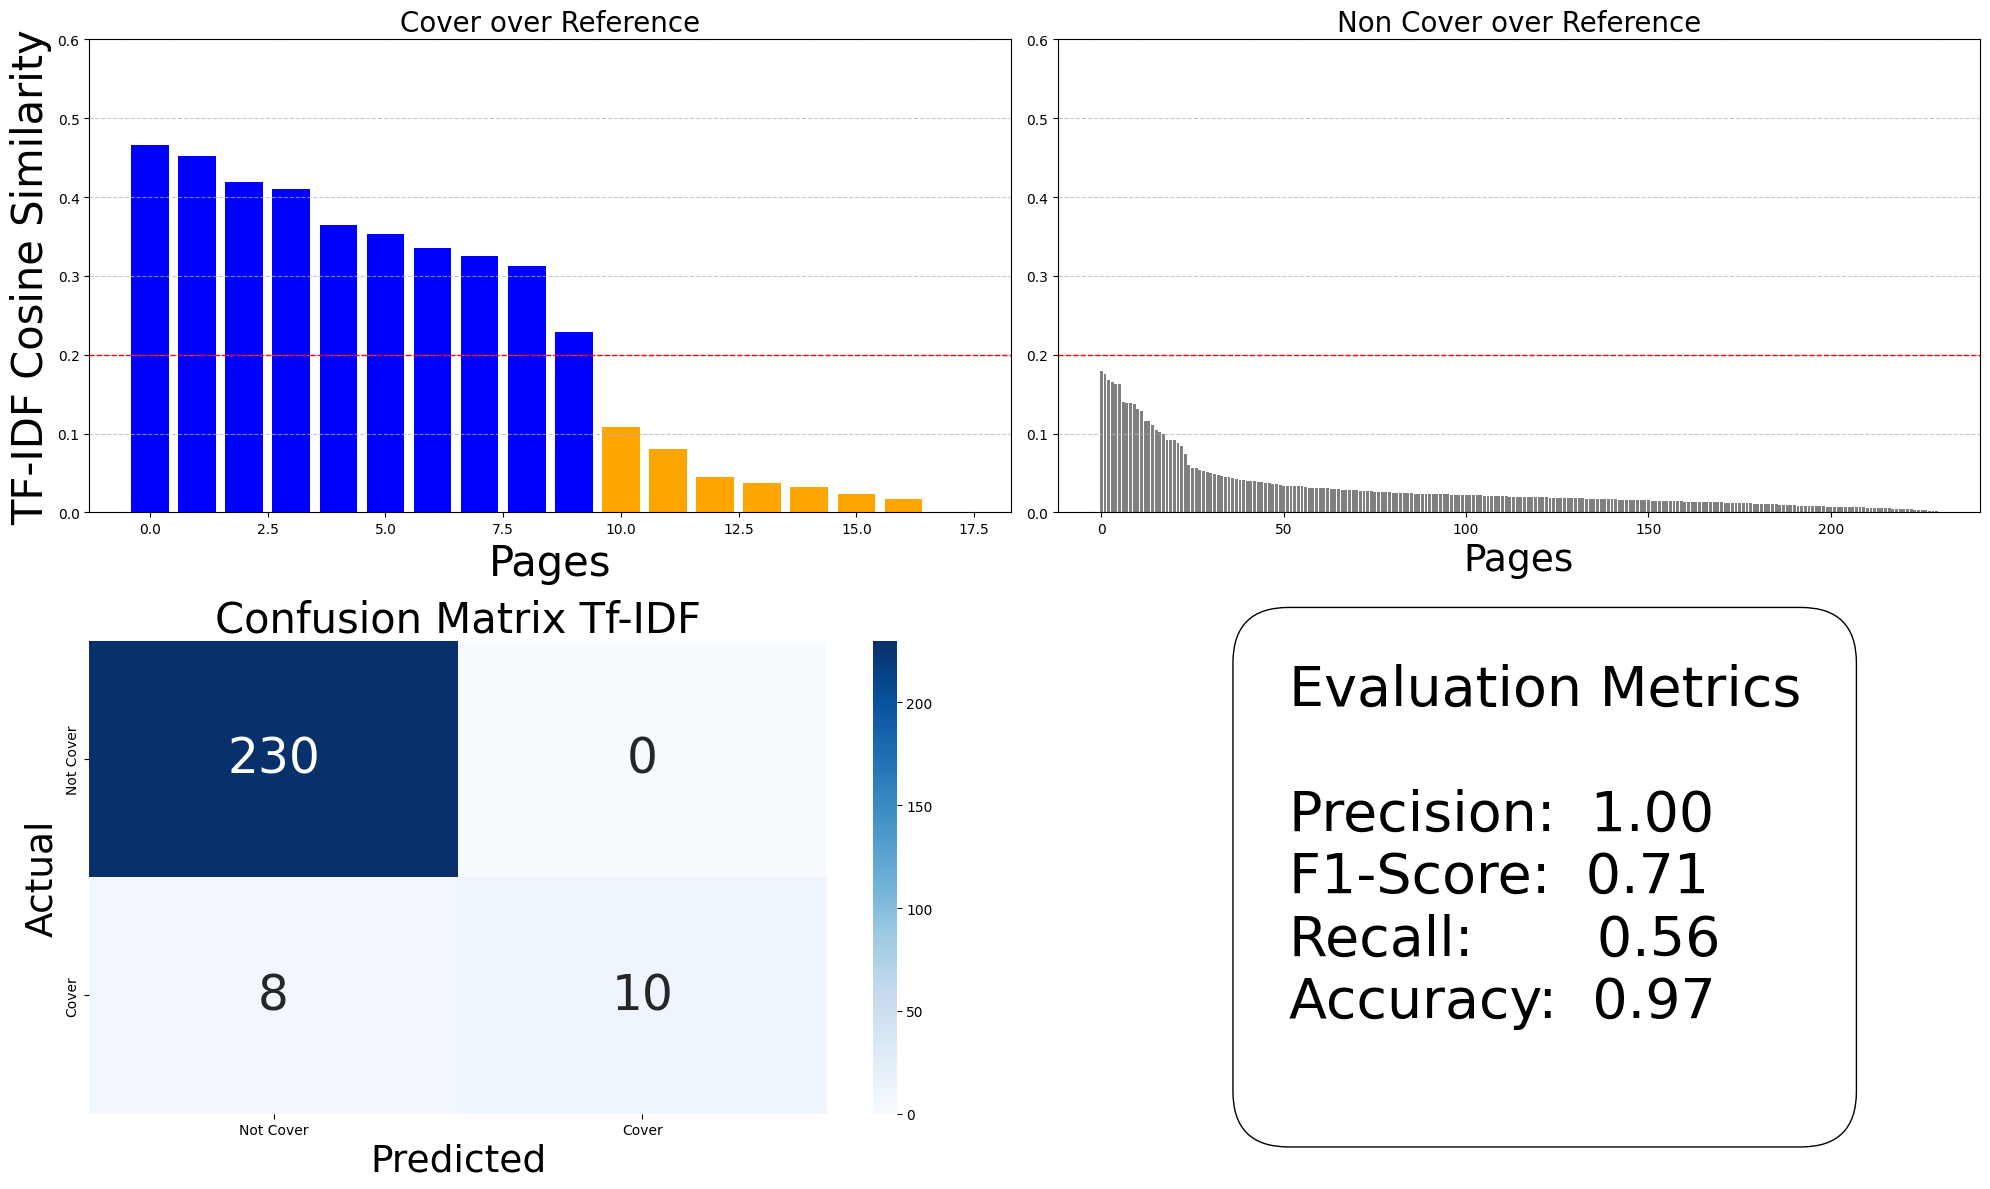

In [6]:
# load reference cover
with open('references/reference_cover.txt', 'r') as f:
    reference_cover = f.read()

fps = first_pages_test['masked_text'].to_list()

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2, 3),            # Unigrams and Bigrams
    tokenizer=None,                # Use default tokenizer or specify your own
    preprocessor=None,             # Use default preprocessor or specify your own
)

# Create TF-IDF Vectors
all_texts = [reference_cover] + fps

vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    tokenizer=None,
    preprocessor=None
)

tfidf_matrix = vectorizer.fit_transform(all_texts)

# Compute Cosine Similarity
reference_vector = tfidf_matrix[0:1]  # reference text
fps_vectors = tfidf_matrix[1:]       # other texts

similarities = cosine_similarity(reference_vector, fps_vectors)[0]

# Visualize the Results
first_pages_test['tfidf_cover'] = similarities

sorted_df = first_pages_test.sort_values(by='tfidf_cover', ascending=False).reset_index(drop=True)

# Separate the dataframes
cover_df = sorted_df[sorted_df['cover'] == True]
non_cover_df = sorted_df[sorted_df['cover'] == False]

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))


# ----------------------------
# Top Left: Plot for Cover Pages
# ----------------------------

# Create a color list that sets bar color to orange if value < 0.2, otherwise blue
cover_colors = ['orange' if val < 0.2 else 'blue' for val in cover_df['tfidf_cover']]

axes[0, 0].bar(
    x=range(len(cover_df)), 
    height=cover_df['tfidf_cover'],
    color=cover_colors
)
axes[0, 0].set_title('Cover over Reference', fontsize=20)
axes[0, 0].set_xlabel('Pages', fontsize=30)
axes[0, 0].set_ylabel('TF-IDF Cosine Similarity', fontsize=30)
axes[0, 0].set_ylim(0, 0.6)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line at y = 0.2
axes[0, 0].axhline(y=0.2, color='red', linestyle='--', linewidth=1)

# ----------------------------
# Top Right: Plot for Non-Cover Pages
# ----------------------------

# Create a color list that sets bar color to red if value > 0.2, otherwise grey
non_cover_colors = ['red' if val > 0.2 else 'grey' for val in non_cover_df['tfidf_cover']]

axes[0, 1].bar(
    x=range(len(non_cover_df)), 
    height=non_cover_df['tfidf_cover'],
    color=non_cover_colors
)
axes[0, 1].set_title('Non Cover over Reference', fontsize=20)
axes[0, 1].set_xlabel('Pages', fontsize=27)
axes[0, 1].set_ylim(0, 0.6)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line at y = 0.2
axes[0, 1].axhline(y=0.2, color='red', linestyle='--', linewidth=1)


# ----------------------------
# Bottom Left: Confusion Matrix
# ----------------------------
# Create a new column 'predicted_cover' based on the threshold
first_pages_test['predicted_cover'] = first_pages_test['tfidf_cover'] >= threshold

# Compute confusion matrix
cm = confusion_matrix(first_pages_test['cover'], first_pages_test['predicted_cover'])

# Define labels
labels = ['Not Cover', 'Cover']

# Create a DataFrame for better readability in the plot
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            annot_kws={"size": 35})
axes[1, 0].set_title('Confusion Matrix Tf-IDF', fontsize=30)
axes[1, 0].set_ylabel('Actual', fontsize=27)
axes[1, 0].set_xlabel('Predicted', fontsize=27)


# ----------------------------
# Bottom Right: Metrics Text
# ----------------------------
# Calculate metrics
accuracy = accuracy_score(first_pages_test['cover'], first_pages_test['predicted_cover'])
precision = precision_score(first_pages_test['cover'], first_pages_test['predicted_cover'], zero_division=0)
recall = recall_score(first_pages_test['cover'], first_pages_test['predicted_cover'], zero_division=0)
f1 = f1_score(first_pages_test['cover'], first_pages_test['predicted_cover'], zero_division=0)

# Prepare the metrics text
metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:  {f1:.2f}\n"
    f"Recall:       {recall:.2f}\n"
    f"Accuracy:  {accuracy:.2f}\n"

)

# Hide the axes for the text plot
axes[1, 1].axis('off')

# Add the text to the plot
axes[1, 1].text(0.25, 0.5, metrics_text, 
               horizontalalignment='left', 
               verticalalignment='center', 
               fontsize=40, 
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

# ----------------------------
# Final Adjustments
# ----------------------------
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

# drop predicted_cover
first_pages_test = first_pages_test.drop(columns='predicted_cover')



## Examine False Negatives

In [7]:
for  i, p in first_pages_test[(first_pages_test['cover'] == True)&(first_pages_test['tfidf_cover']<0.2)].iterrows():
    print(i)
    print(p['clean_text'])
    print()
    print(p['masked_text'])
    print('-------------------')

54
exhibit index begins on page
90

exhibit index begins page 90
-------------------
84
information concerning forward looking statements
this annual report on form 10 k contains "forward looking statements," as defined in the private securities litigation reform act of 1995. these statements, which express management's current views concerning future events or results, use words like "anticipate," "assume," "believe," "continue," "estimate," "expect," "intend," "plan," "project" and similar terms, and future or conditional tense verbs like "could," "may," "might," "should," "will" and "would".
forward looking statements are subject to inherent risks and uncertainties that could cause actual results to differ materially from those expressed or implied in our forwardlooking statements. factors that could materially affect our future results include, among other things:
the impact of geopolitical or macroeconomic conditions on us, our clients and the countries and industries in which we 

## Table of Contents

In [8]:
threshold = 0.04
ttoc = threshold

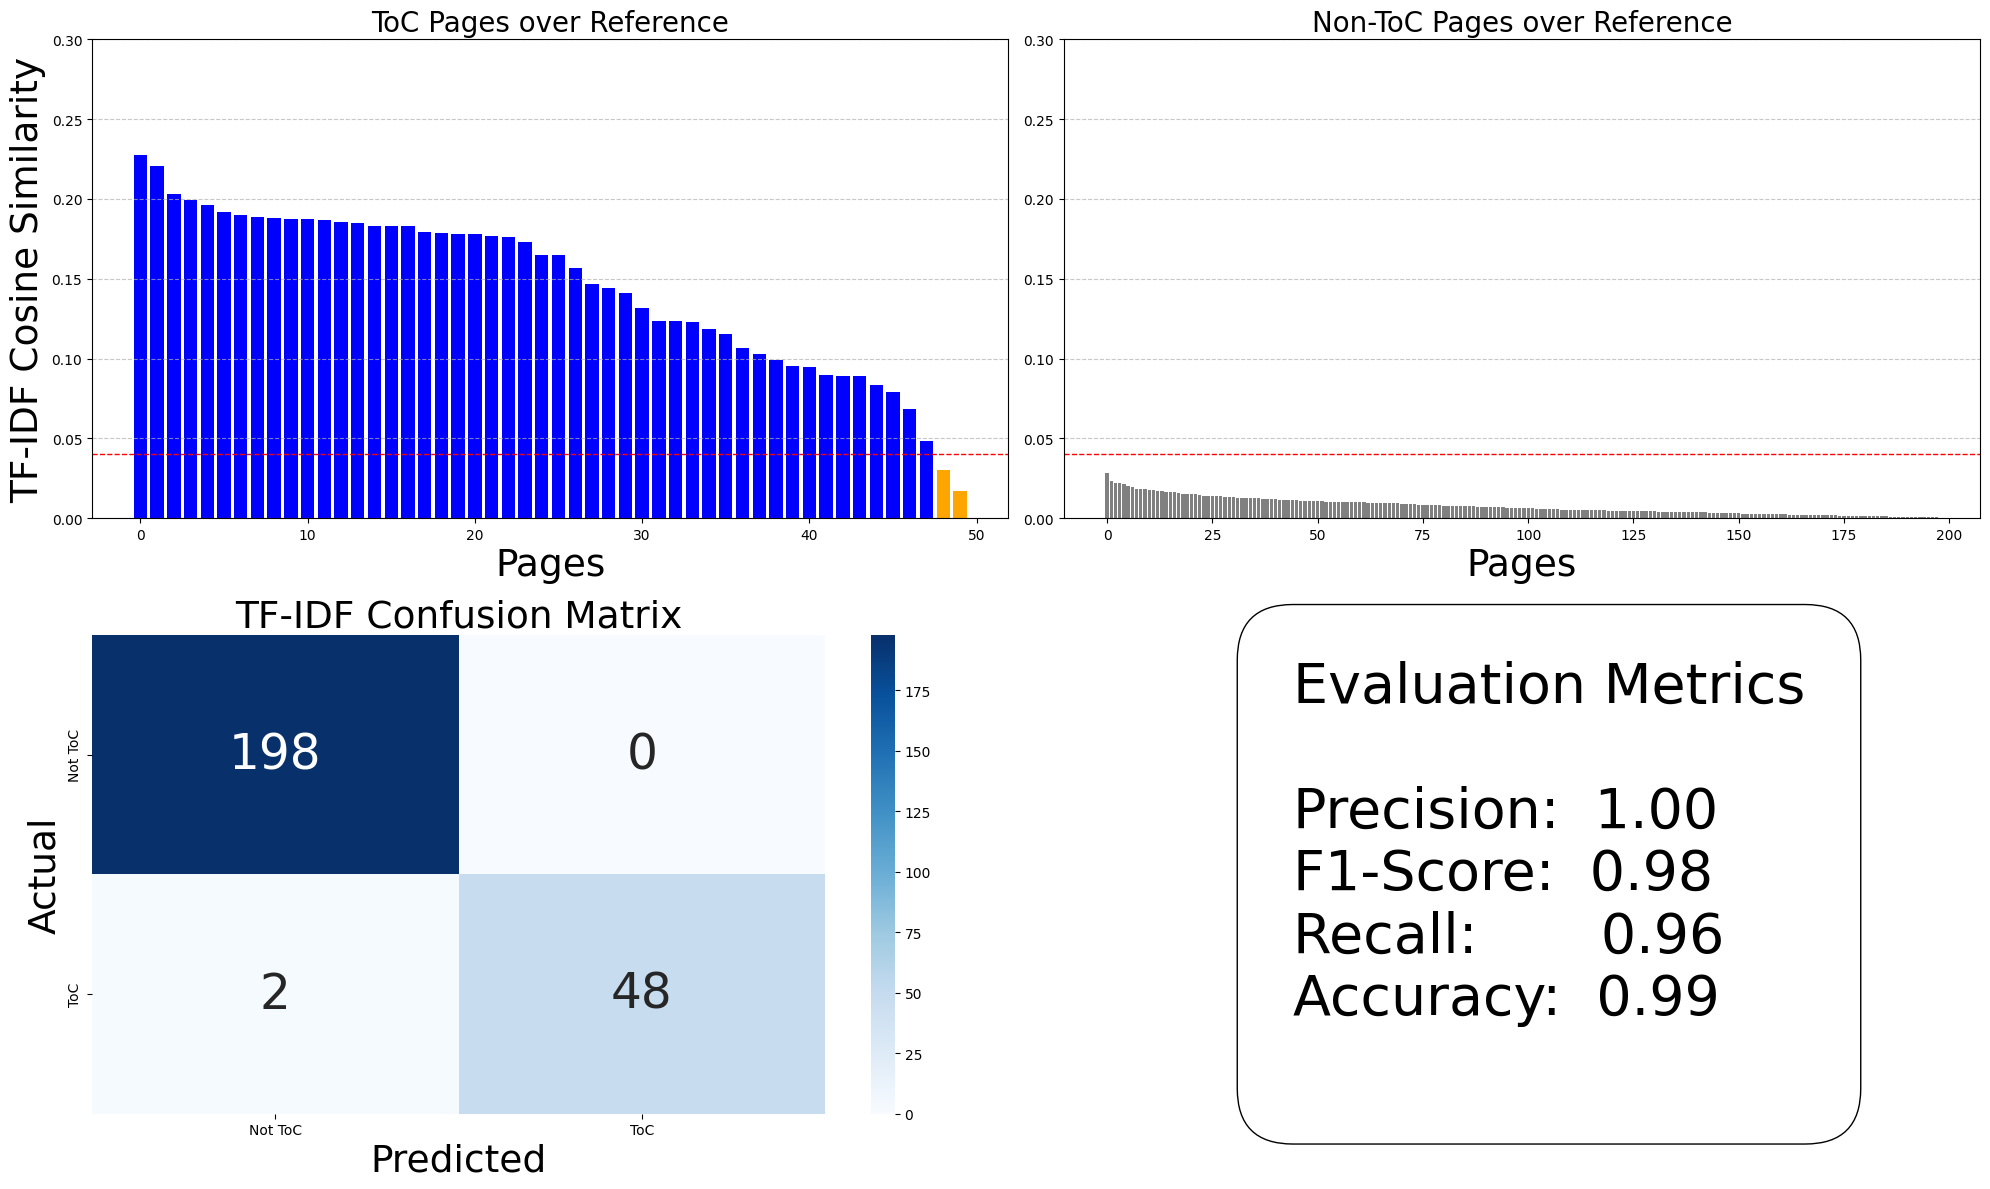

In [9]:
# load reference cover
with open('references/reference_toc.txt', 'r') as f:
    reference_toc = f.read()

fps = first_pages_test['masked_text'].to_list()

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2, 3),            # Unigrams and Bigrams
    tokenizer=None,                # Use default tokenizer or specify your own
    preprocessor=None,             # Use default preprocessor or specify your own
)

# Create TF-IDF Vectors
all_texts = [reference_toc] + fps

vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    tokenizer=None,
    preprocessor=None
)

tfidf_matrix = vectorizer.fit_transform(all_texts)

# Compute Cosine Similarity
reference_vector = tfidf_matrix[0:1]  # reference text
fps_vectors = tfidf_matrix[1:]       # other texts

similarities = cosine_similarity(reference_vector, fps_vectors)[0]

# Visualize the Results
first_pages_test['tfidf_toc'] = similarities

sorted_df = first_pages_test.sort_values(by='tfidf_toc', ascending=False).reset_index(drop=True)

# Separate the dataframes
toc_df = sorted_df[sorted_df['toc'] == True]
non_toc_df = sorted_df[sorted_df['toc'] == False]

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# ----------------------------
# Top Left: Plot for ToC Pages
# ----------------------------
# Create a color list that sets bar color to orange if value < threshold, otherwise blue
toc_colors = [
    'orange' if val < threshold else 'blue'
    for val in toc_df['tfidf_toc']
]

axes[0, 0].bar(
    x=range(len(toc_df)),
    height=toc_df['tfidf_toc'],
    color=toc_colors
)
axes[0, 0].set_title('ToC Pages over Reference', fontsize=20)
axes[0, 0].set_xlabel('Pages', fontsize=27)
axes[0, 0].set_ylabel('TF-IDF Cosine Similarity', fontsize=27)
axes[0, 0].set_ylim(0, 0.3)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line at y = threshold
axes[0, 0].axhline(y=threshold, color='red', linestyle='--', linewidth=1)

# ----------------------------
# Top Right: Plot for Non-ToC Pages
# ----------------------------
# Create a color list that sets bar color to red if value > threshold, otherwise grey
non_toc_colors = [
    'red' if val > threshold else 'grey'
    for val in non_toc_df['tfidf_toc']
]

axes[0, 1].bar(
    x=range(len(non_toc_df)),
    height=non_toc_df['tfidf_toc'],
    color=non_toc_colors
)
axes[0, 1].set_title('Non-ToC Pages over Reference', fontsize=20)
axes[0, 1].set_xlabel('Pages', fontsize=27)
axes[0, 1].set_ylim(0, 0.3)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line at y = threshold
axes[0, 1].axhline(y=threshold, color='red', linestyle='--', linewidth=1)


# ----------------------------
# Bottom Left: Confusion Matrix
# ----------------------------
# Create a new column 'predicted_toc' based on the threshold
first_pages_test['predicted_toc'] = first_pages_test['tfidf_toc'] >= threshold

# Compute confusion matrix
cm = confusion_matrix(first_pages_test['toc'], first_pages_test['predicted_toc'])

# Define labels
labels = ['Not ToC', 'ToC']

# Create a DataFrame for better readability in the plot
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            annot_kws={"size": 35})
axes[1, 0].set_title('TF-IDF Confusion Matrix', fontsize=27)
axes[1, 0].set_ylabel('Actual', fontsize=27)
axes[1, 0].set_xlabel('Predicted', fontsize=27)

# ----------------------------
# Bottom Right: Metrics Text
# ----------------------------
# Calculate metrics
accuracy = accuracy_score(first_pages_test['toc'], first_pages_test['predicted_toc'])
precision = precision_score(first_pages_test['toc'], first_pages_test['predicted_toc'], zero_division=0)
recall = recall_score(first_pages_test['toc'], first_pages_test['predicted_toc'], zero_division=0)
f1 = f1_score(first_pages_test['toc'], first_pages_test['predicted_toc'], zero_division=0)

# Prepare the metrics text
metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:  {f1:.2f}\n"
    f"Recall:       {recall:.2f}\n"
    f"Accuracy:  {accuracy:.2f}\n"

)

# Hide the axes for the text plot
axes[1, 1].axis('off')

# Add the text to the plot
axes[1, 1].text(0.25, 0.5, metrics_text, 
               horizontalalignment='left', 
               verticalalignment='center', 
               fontsize=40, 
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

# ----------------------------
# Final Adjustments
# ----------------------------
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

# drop predicted_toc
first_pages_test = first_pages_test.drop(columns='predicted_toc')



## Examine False Negatives

In [10]:
for  i, p in first_pages_test[(first_pages_test['toc'] == True)&(first_pages_test['tfidf_toc']<0.05)].iterrows():
    print(i)
    print(p['clean_text'])
    print()
    print(p['masked_text'])
    print('-------------------')


56
table of contents
(continued)
part iv
item 15 exhibits and financial statement schedules 90
signatures 94
ford motor company and subsidiaries financial statements
report of independent registered public accounting firm fs 1 consolidated income statement fs 2 consolidated statement of comprehensive income fs 2 sector income statement fs 3 consolidated balance sheet fs 4 sector balance sheet fs 5 condensed consolidated statement of cash flows fs 6 condensed sector statement of cash flows fs 7
consolidated statement of equity fs 8
notes to the financial statements fs 9
schedule ii — valuation and qualifying accounts fss 1
ii

table contents continued part iv item 15 exhibits financial statement schedules 90 signatures 94 ford motor company subsidiaries financial statements report independent registered public accounting firm fs 1 consolidated income statement fs 2 consolidated statement comprehensive income fs 2 sector income statement fs 3 consolidated balance sheet fs 4 sector balanc

# Embeddings

In [11]:
with io.open('/Users/emanueleferrari/desktop/Key.txt', 'r', encoding='utf-8') as file:
        api_key = file.read().strip()

os.environ['OPENAI_API_KEY'] = api_key
del api_key

client = OpenAI()


In [12]:
def get_embedding(text, model="text-embedding-3-small"):
   return client.embeddings.create(input = [text], model=model).data[0].embedding

def get_embeddings(df, model="text-embedding-3-small"):
   df = df.copy()
   embeddings = []
   for text in tqdm(df['masked_text'], desc='Getting embeddings'):
      embeddings.append(get_embedding(text, model=model))
   df['emb'] = embeddings
   return df


In [13]:
def geometric_median(points, max_iter=1000, tol=1e-7):
    """
    Compute the geometric median of a set of points in R^D using Weiszfeld's algorithm.
    
    Parameters:
    - points: array-like, shape (N, D)
        A set of N points in D-dimensional space.
    - max_iter: int, default=1000
        Maximum number of iterations.
    - tol: float, default=1e-7
        Tolerance for convergence.
        
    Returns:
    - median: ndarray, shape (D,)
        The geometric median of the input points.
    """
    # Convert input to NumPy array
    points = np.asarray(points)
    
    # Ensure points is 2D
    if points.ndim == 1:
        points = points.reshape(-1, 1)
    elif points.ndim != 2:
        raise ValueError("Input points must be a 1D or 2D array.")
    
    # Start guess: the centroid (arithmetic mean)
    current = np.mean(points, axis=0)
    
    for i in range(max_iter):
        # Compute distances from current guess to all points
        distances = np.linalg.norm(points - current, axis=1)
        
        # To avoid division by zero, handle points that coincide with current
        mask_nonzero = distances != 0
        if not np.any(mask_nonzero):
            # All points coincide with the current guess
            return current
        
        # Compute weights: inverse of distances
        weights = np.zeros_like(distances)
        weights[mask_nonzero] = 1.0 / distances[mask_nonzero]
        
        # Compute the weighted sum of points
        numerator = (points.T * weights).sum(axis=1)
        denominator = weights.sum()
        
        # Update the current guess
        new_current = numerator / denominator
        
        # Check for convergence
        shift = np.linalg.norm(new_current - current)
        if shift < tol:
            return new_current
        
        current = new_current
    
    return current

def plot_histogram(ax, data, threshold, colors, title, xlabel, ylabel, bins, range_min, range_max):
    # Calculate histogram data
    counts, bin_edges = np.histogram(data, bins=bins, range=(range_min, range_max))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Assign colors based on bin centers
    bin_colors = [colors['below'] if center < threshold else colors['above'] for center in bin_centers]

    # Width of each bin
    bin_width = bin_edges[1] - bin_edges[0]

    # Plot bars
    ax.bar(bin_centers, counts, width=bin_width, color=bin_colors, alpha=0.7, edgecolor='black')

    # Add vertical line at threshold
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2)

    # Set titles and labels
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)


## Get Embeddings

In [14]:
# first_pages_test = get_embeddings(first_pages_test)

# # save first_pages_test as first_pages_testemb
# first_pages_test.to_parquet('labelled/first_pages_test_emb.parquet') 


# load first_pages
first_pages_test = pd.read_parquet('labelled/first_pages_test_emb.parquet')
# first_pages.head()

## Load References

In [15]:
# emb_cover = first_pages_test[first_pages_test['cover']]['emb'].to_list()

# centroid_cover = np.mean(emb_cover, axis=0)
# median_cover = geometric_median(emb_cover)

# print("Cover centroid:", centroid_cover)
# print("Cover median:", median_cover)

# # save the centroid and median
# np.save('references/centroid_cover.npy', centroid_cover)
# np.save('references/median_cover.npy', median_cover)

# emb_toc = first_pages_test[first_pages_test['toc']]['emb'].to_list()

# centroid_toc = np.mean(emb_toc, axis=0)
# median_toc = geometric_median(emb_toc)

# print("ToC centroid:", centroid_toc)
# print("ToC median:", median_toc)

# # save the centroid and median
# np.save('references/centroid_toc.npy', centroid_toc)
# np.save('references/median_toc.npy', median_toc)

# load centroid and median
centroid_cover = np.load('references/centroid_cover.npy')
median_cover = np.load('references/median_cover.npy')
centroid_toc = np.load('references/centroid_toc.npy')
median_toc = np.load('references/median_toc.npy')


## Cover Page

In [16]:
threshold = 0.82
tcp = threshold

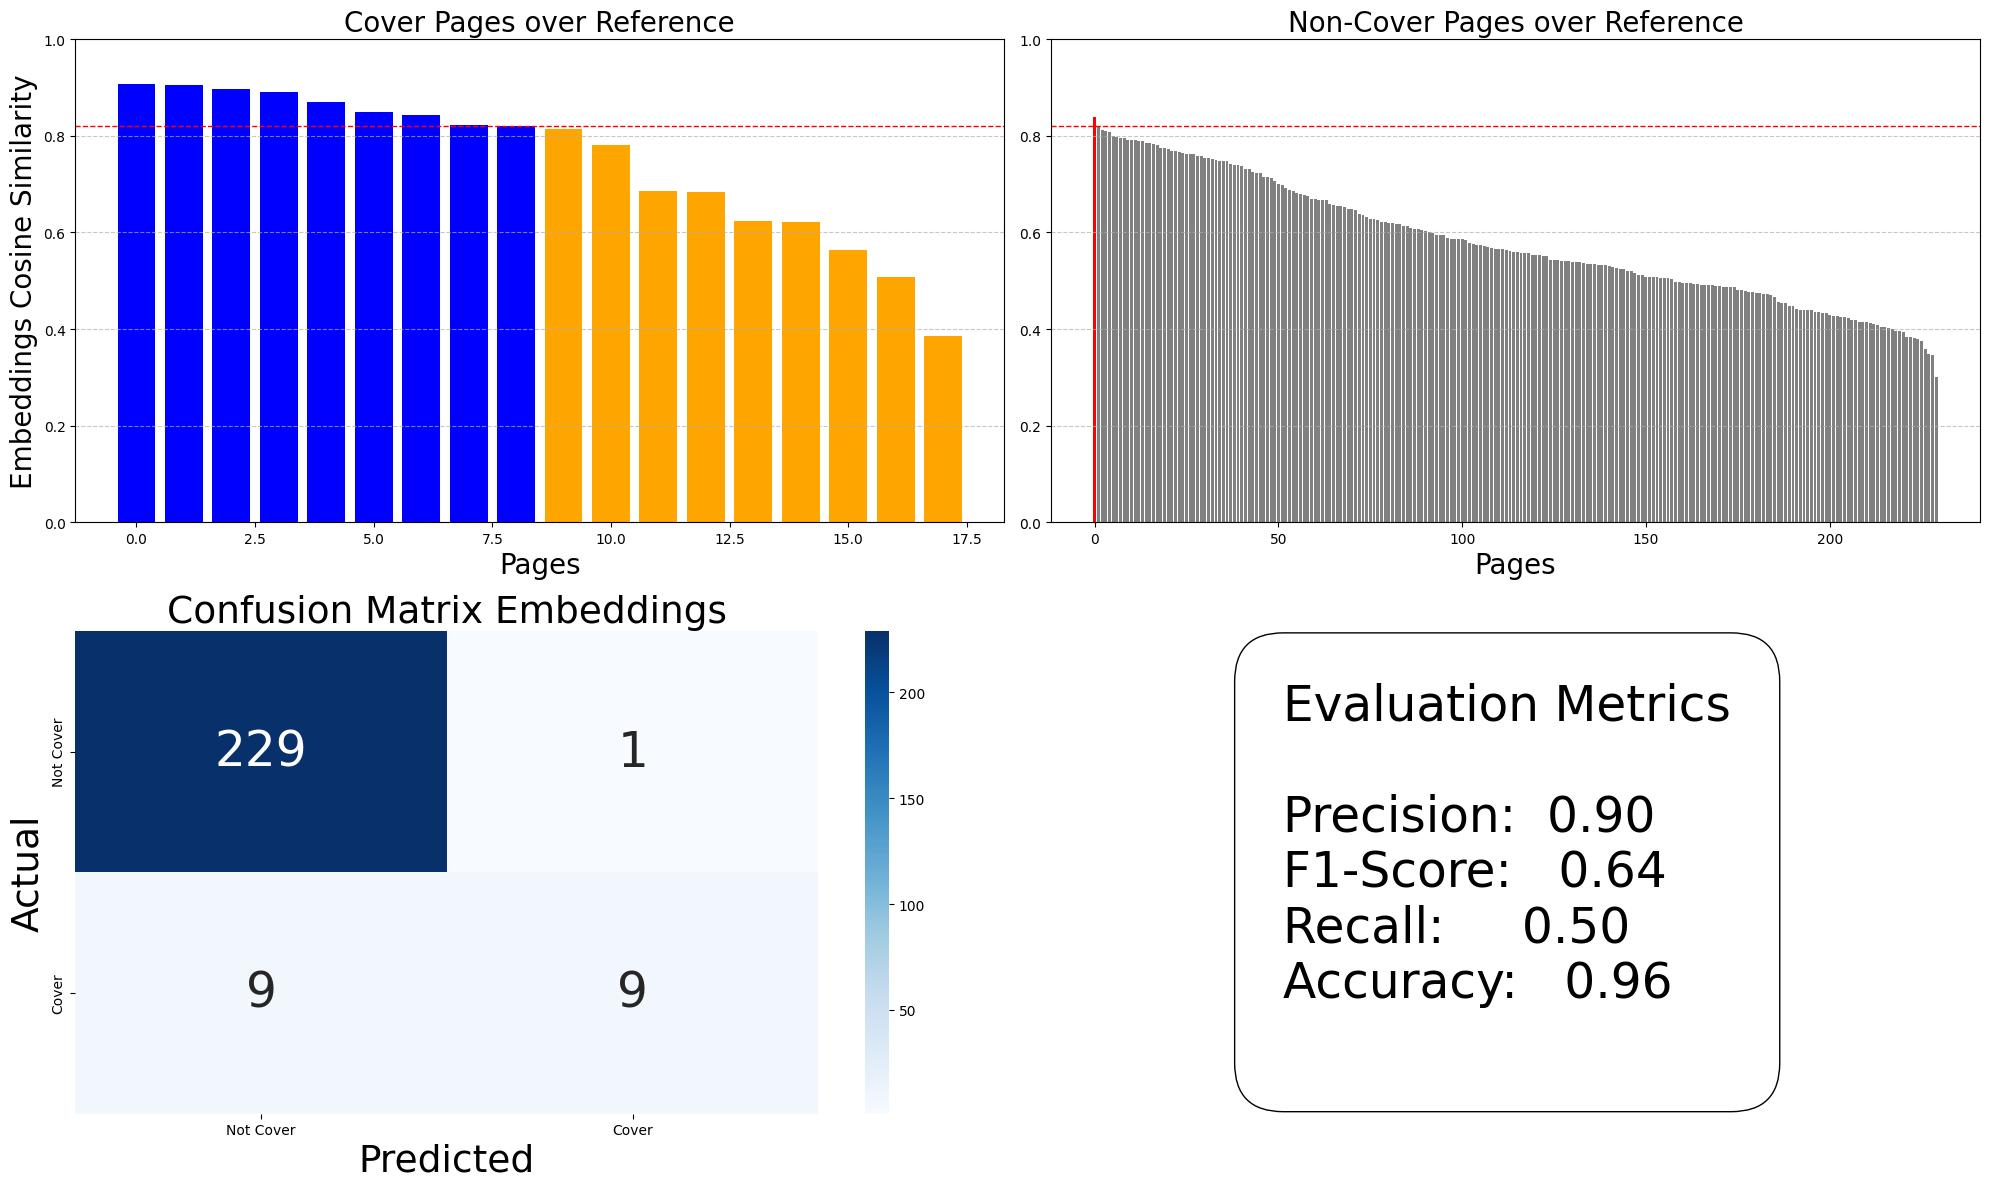

In [17]:
# 1) Compute 'emb_sim_cover' using centroid_cover

cover_centroid_array = np.array(centroid_cover).reshape(1, -1)  # shape (1, embedding_dim)
emb_array = np.stack(first_pages_test['emb'].to_numpy())             # shape (n_samples, embedding_dim)

# Calculate cosine similarity for each row to cover centroid
similarities = pairwise.cosine_similarity(emb_array, cover_centroid_array)
first_pages_test['emb_sim_cover'] = similarities.ravel()  # Flatten to 1D

# ------------------------------------------------
# 2) Split into COVER and NON-COVER subsets
# ------------------------------------------------
cover_df = first_pages_test[first_pages_test['cover'] == True].sort_values(by='emb_sim_cover', ascending=False)
non_cover_df = first_pages_test[first_pages_test['cover'] == False].sort_values(by='emb_sim_cover', ascending=False)

# ------------------------------------------------
# 3) Create a binary prediction using a threshold
# ------------------------------------------------
cover_threshold = threshold
first_pages_test['predicted_cover'] = first_pages_test['emb_sim_cover'] >= cover_threshold

# ------------------------------------------------
# 4) Create a 2x2 subplot grid for visualization
# ------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# ----------------------------
# Top Left: Plot for Cover Pages
# ----------------------------
# Create a color list that sets bar color to orange if value < threshold, otherwise blue
cover_colors = [
    'orange' if val < threshold else 'blue' 
    for val in cover_df['emb_sim_cover']
]

axes[0, 0].bar(
    x=range(len(cover_df)),                          
    height=cover_df['emb_sim_cover'],               
    color=cover_colors
)
axes[0, 0].set_title('Cover Pages over Reference', fontsize=20)
axes[0, 0].set_xlabel('Pages', fontsize=20)
axes[0, 0].set_ylabel('Embeddings Cosine Similarity', fontsize=20)
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line at y = threshold
axes[0, 0].axhline(y=threshold, color='red', linestyle='--', linewidth=1)

# ----------------------------
# Top Right: Plot for Non-Cover Pages
# ----------------------------
# Create a color list that sets bar color to red if value > threshold, otherwise grey
non_cover_colors = [
    'red' if val > threshold else 'grey' 
    for val in non_cover_df['emb_sim_cover']
]

axes[0, 1].bar(
    x=range(len(non_cover_df)),                    
    height=non_cover_df['emb_sim_cover'],          
    color=non_cover_colors
)
axes[0, 1].set_title('Non-Cover Pages over Reference', fontsize=20)
axes[0, 1].set_xlabel('Pages', fontsize=20)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line at y = threshold
axes[0, 1].axhline(y=threshold, color='red', linestyle='--', linewidth=1)


# ----------------------------
# Bottom Left: Confusion Matrix
# ----------------------------
cm = confusion_matrix(first_pages_test['cover'], first_pages_test['predicted_cover'])
labels = ['Not Cover', 'Cover']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

sns.heatmap(
    cm_df, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=axes[1, 0],
    annot_kws={"size": 35}
)
axes[1, 0].set_title('Confusion Matrix Embeddings', fontsize=27)
axes[1, 0].set_ylabel('Actual', fontsize=27)
axes[1, 0].set_xlabel('Predicted', fontsize=27)

# ----------------------------
# Bottom Right: Metrics Text
# ----------------------------
accuracy = accuracy_score(first_pages_test['cover'], first_pages_test['predicted_cover'])
precision = precision_score(first_pages_test['cover'], first_pages_test['predicted_cover'], zero_division=0)
recall = recall_score(first_pages_test['cover'], first_pages_test['predicted_cover'], zero_division=0)
f1 = f1_score(first_pages_test['cover'], first_pages_test['predicted_cover'], zero_division=0)

metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:   {f1:.2f}\n"
    f"Recall:     {recall:.2f}\n"
    f"Accuracy:   {accuracy:.2f}\n"
)

axes[1, 1].axis('off')
axes[1, 1].text(
    0.25, 0.5, 
    metrics_text, 
    horizontalalignment='left', 
    verticalalignment='center', 
    fontsize=35, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
)

plt.tight_layout()
plt.show()

# ---------------------------------------
# (Optional) Drop the predicted_cover column
# ---------------------------------------
first_pages_test.drop(columns='predicted_cover', inplace=True)


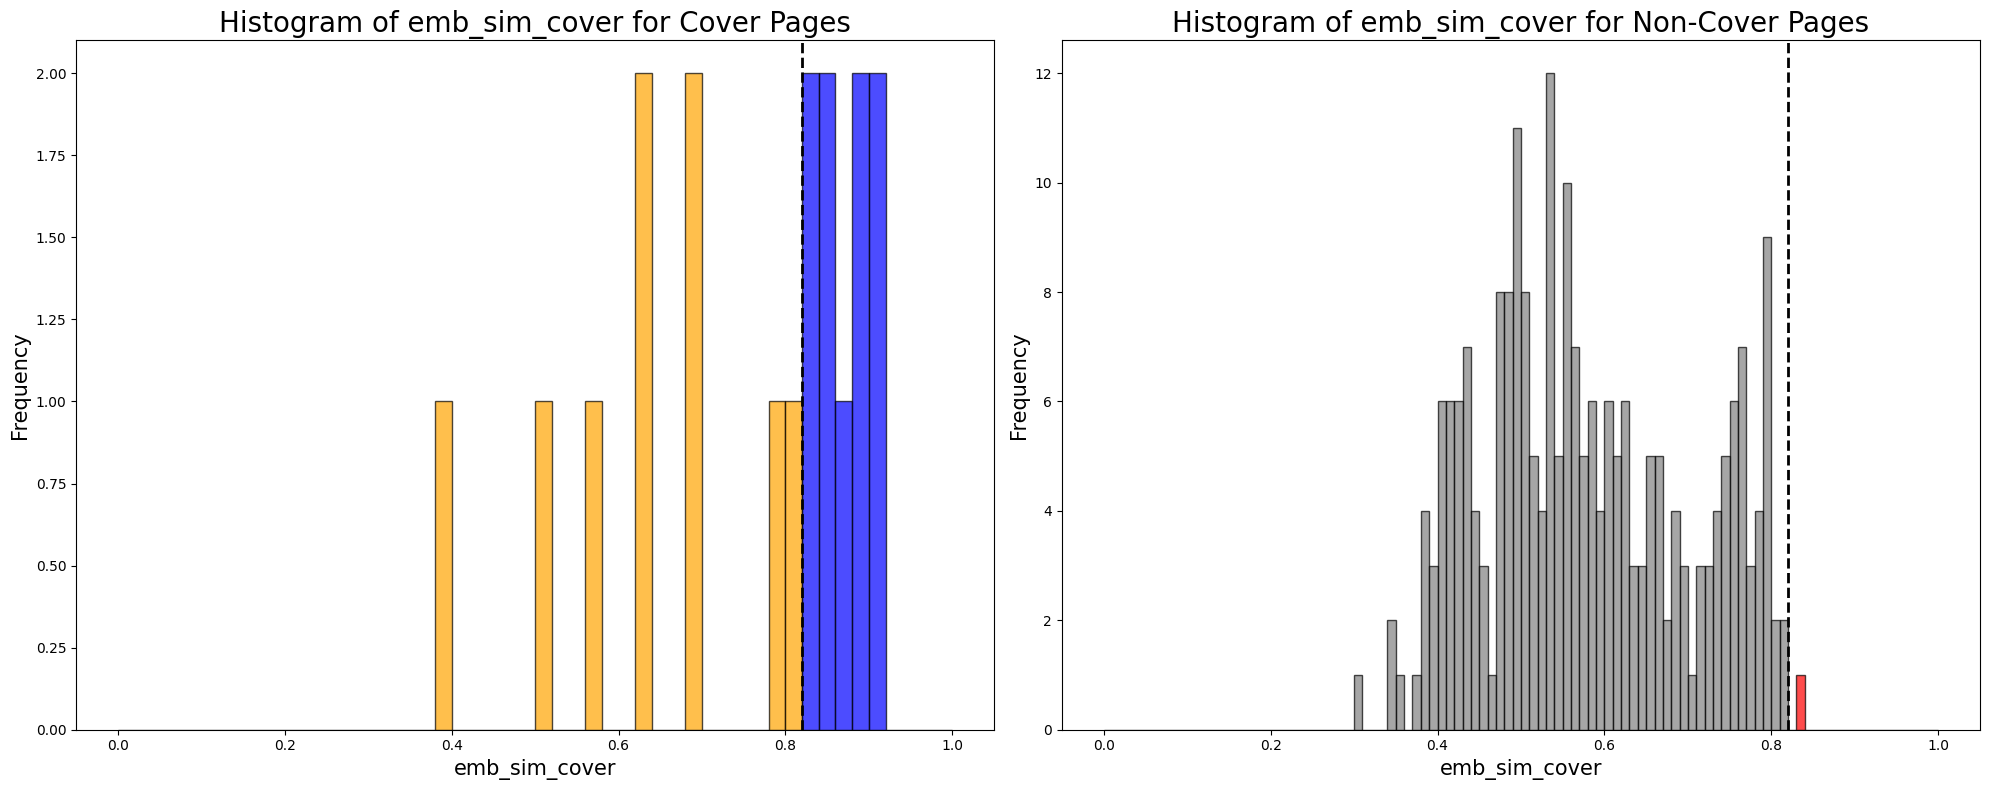

In [18]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Filter and sort data
cover_df = first_pages_test[first_pages_test['cover'] == True].sort_values(by='emb_sim_cover')
non_cover_df = first_pages_test[first_pages_test['cover'] == False].sort_values(by='emb_sim_cover')

# Define color schemes
cover_colors = {'below': 'orange', 'above': 'blue'}
non_cover_colors = {'below': 'grey', 'above': 'red'}

# Plot for Cover Pages (cover == True)
plot_histogram(
    ax=axes[0],
    data=cover_df['emb_sim_cover'],
    threshold=threshold,
    colors=cover_colors,
    title='Histogram of emb_sim_cover for Cover Pages',
    xlabel='emb_sim_cover',
    ylabel='Frequency',
    bins=50,
    range_min=0,
    range_max=1
)

bins = 100
# Plot for Non-Cover Pages (cover == False)
plot_histogram(
    ax=axes[1],
    data=non_cover_df['emb_sim_cover'],
    threshold=threshold,
    colors=non_cover_colors,
    title='Histogram of emb_sim_cover for Non-Cover Pages',
    xlabel='emb_sim_cover',
    ylabel='Frequency',
    bins=100,
    range_min=0,
    range_max=1
)

# Adjust layout and display
plt.tight_layout()
plt.show()


### Analyze False Negatives

In [19]:
for  i, p in first_pages_test[(first_pages_test['cover'] == True)&(first_pages_test['emb_sim_cover']<threshold)].iterrows():
    print(i)
    print(p['clean_text'])
    print()
    print(p['masked_text'])
    print('-------------------')

44
indicate by check mark whether the registrant is a large accelerated filer, an accelerated filer, a non accelerated filer, a smaller reporting company, or an emerging growth company. see the definitions of “large accelerated filer,” “accelerated filer,” “smaller reporting company,” and "emerging growth company" in rule 12b 2 of the exchange act. large accelerated filer  accelerated filer  non accelerated filer  (do not check if a smaller reporting company) smaller reporting company  emerging growth company 
if an emerging growth company, indicate by check mark if the registrant has elected not to use the extended transition period for complying with any new or revised financial accounting standards provided pursuant to section 13(a) of the exchange act. 
indicate by check mark whether the registrant is a shell company (as defined in rule 12b 2 of the act). yes  no 
aggregate market value of the voting stock held by nonaffiliates of the registrant as of close of business on m

## Table of Contents

In [20]:
threshold = 0.76

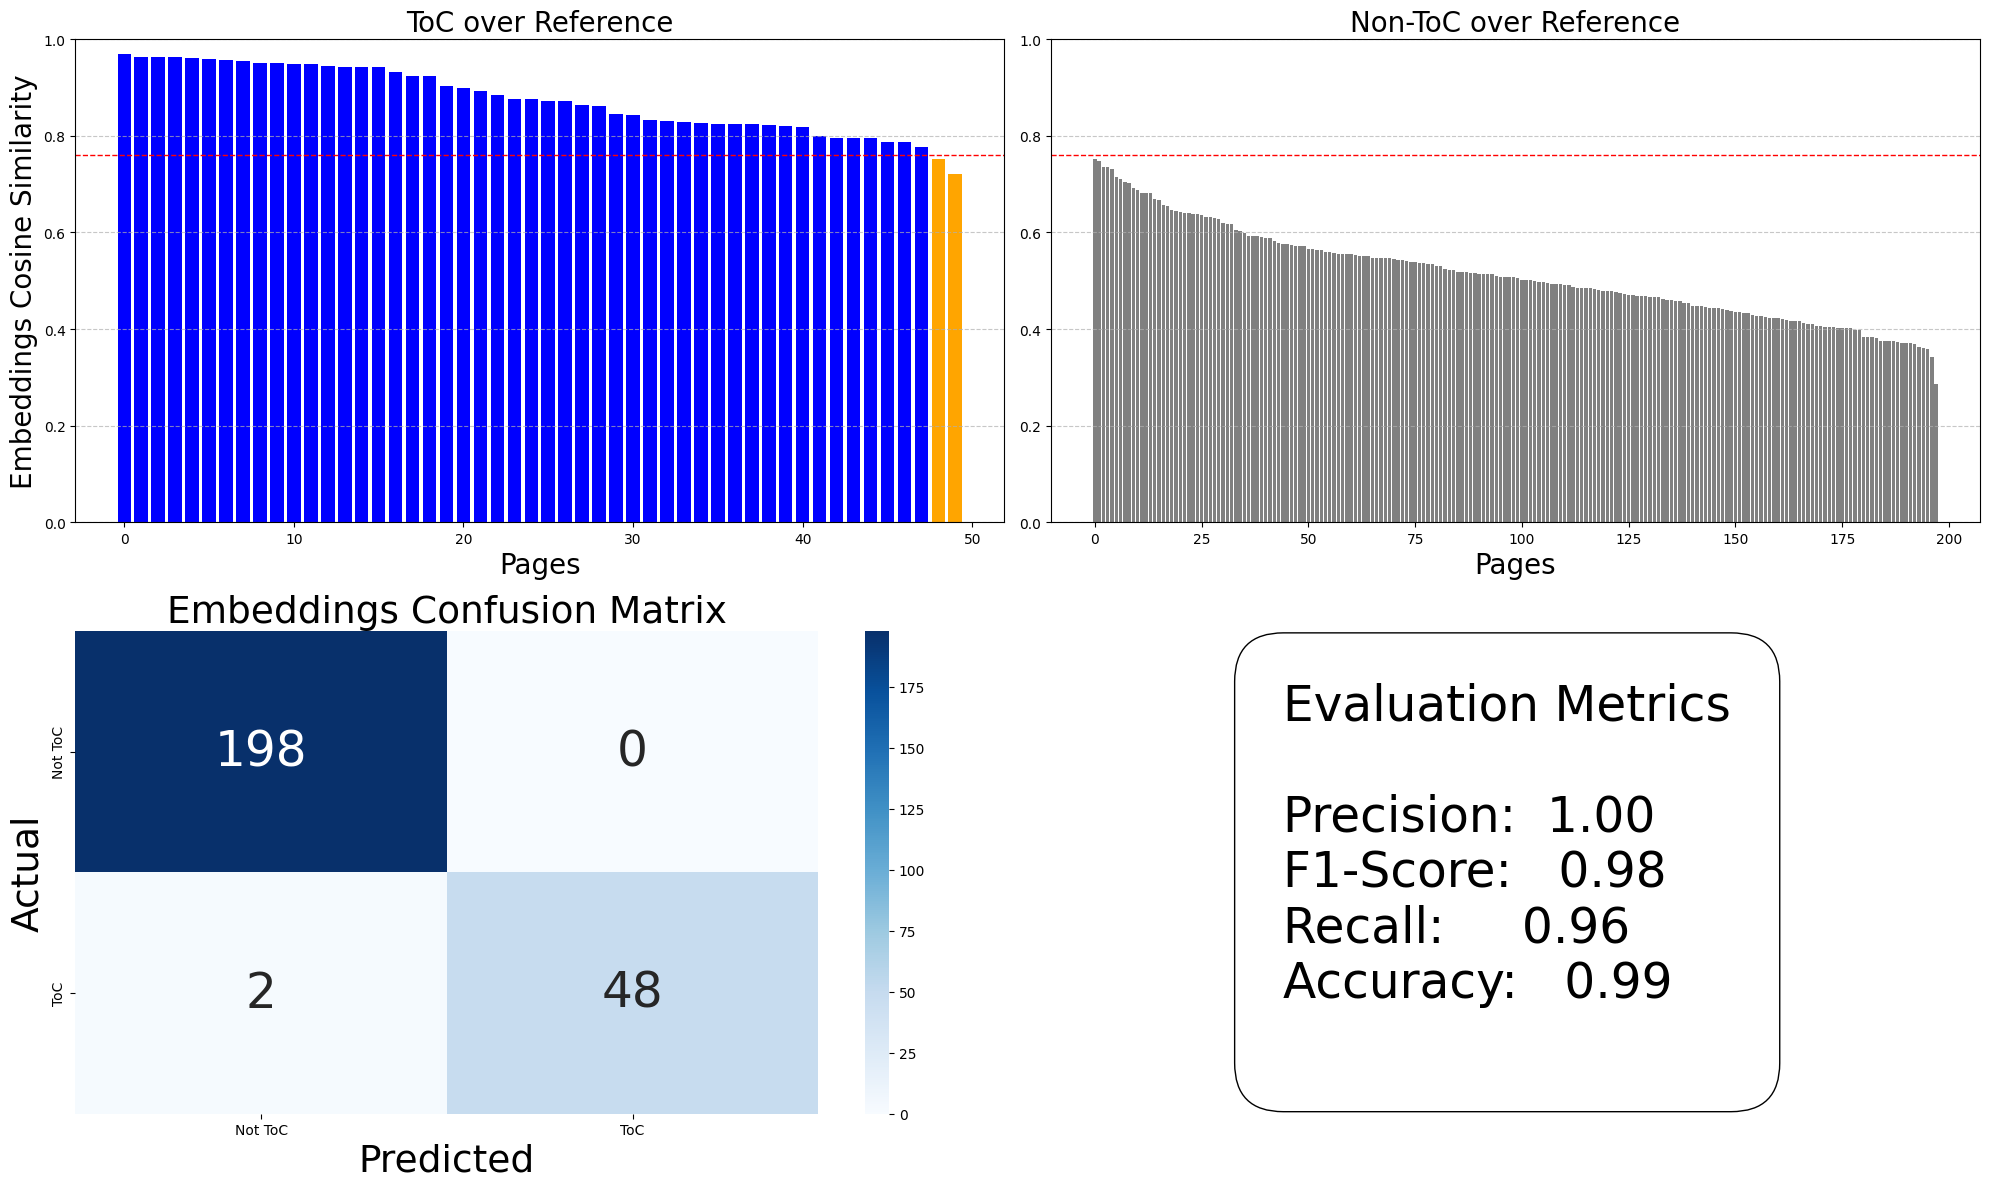

In [21]:
# 1) Compute 'emb_sim_toc' using centroid_toc
# ------------------------------------------------
toc_centroid_array = np.array(centroid_toc).reshape(1, -1)  # shape (1, embedding_dim)
emb_array = np.stack(first_pages_test['emb'].to_numpy())         # shape (n_samples, embedding_dim)

# Calculate cosine similarity for each row to toc centroid
similarities = pairwise.cosine_similarity(emb_array, toc_centroid_array)
first_pages_test['emb_sim_toc'] = similarities.ravel()

# ------------------------------------------------
# 2) Split into TOC and NON-TOC subsets
# ------------------------------------------------
toc_df = first_pages_test[first_pages_test['toc'] == True].sort_values(by='emb_sim_toc', ascending=False)
non_toc_df = first_pages_test[first_pages_test['toc'] == False].sort_values(by='emb_sim_toc', ascending=False)

# ------------------------------------------------
# 3) Create a binary prediction using a threshold
# ------------------------------------------------
# You can adjust this threshold based on your data
toc_threshold = threshold
first_pages_test['predicted_toc'] = first_pages_test['emb_sim_toc'] >= toc_threshold

# ------------------------------------------------
# 4) Create a 2x2 subplot grid for visualization
# ------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# ----------------------------
# Top Left: Plot for ToC Pages
# ----------------------------
# Create color list for ToC bars:
# Orange if value < threshold, Blue otherwise
toc_colors = [
    'orange' if val < threshold else 'blue'
    for val in toc_df['emb_sim_toc']
]

axes[0, 0].bar(
    x=range(len(toc_df)),                          
    height=toc_df['emb_sim_toc'],                 
    color=toc_colors
)
axes[0, 0].set_title('ToC over Reference', fontsize=20)
axes[0, 0].set_xlabel('Pages', fontsize=20)
axes[0, 0].set_ylabel('Embeddings Cosine Similarity', fontsize=20)
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line at y = threshold
axes[0, 0].axhline(y=threshold, color='red', linestyle='--', linewidth=1)


# ----------------------------
# Top Right: Plot for Non-ToC Pages
# ----------------------------
# Create color list for non-ToC bars:
# Red if value > threshold, Grey otherwise
non_toc_colors = [
    'red' if val > threshold else 'grey'
    for val in non_toc_df['emb_sim_toc']
]

axes[0, 1].bar(
    x=range(len(non_toc_df)),                    
    height=non_toc_df['emb_sim_toc'],           
    color=non_toc_colors
)
axes[0, 1].set_title('Non-ToC over Reference', fontsize=20)
axes[0, 1].set_xlabel('Pages', fontsize=20)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line at y = threshold
axes[0, 1].axhline(y=threshold, color='red', linestyle='--', linewidth=1)

# ----------------------------
# Bottom Left: Confusion Matrix
# ----------------------------
cm = confusion_matrix(first_pages_test['toc'], first_pages_test['predicted_toc'])
labels = ['Not ToC', 'ToC']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

sns.heatmap(
    cm_df, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=axes[1, 0],
    annot_kws={"size": 35}
)
axes[1, 0].set_title('Embeddings Confusion Matrix', fontsize=27)
axes[1, 0].set_ylabel('Actual', fontsize=27)
axes[1, 0].set_xlabel('Predicted', fontsize=27)

# ----------------------------
# Bottom Right: Metrics Text
# ----------------------------
accuracy = accuracy_score(first_pages_test['toc'], first_pages_test['predicted_toc'])
precision = precision_score(first_pages_test['toc'], first_pages_test['predicted_toc'], zero_division=0)
recall = recall_score(first_pages_test['toc'], first_pages_test['predicted_toc'], zero_division=0)
f1 = f1_score(first_pages_test['toc'], first_pages_test['predicted_toc'], zero_division=0)

metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:   {f1:.2f}\n"
    f"Recall:     {recall:.2f}\n"
    f"Accuracy:   {accuracy:.2f}\n"
)

axes[1, 1].axis('off')
axes[1, 1].text(
    0.25, 0.5, 
    metrics_text, 
    horizontalalignment='left', 
    verticalalignment='center', 
    fontsize=35, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
)

plt.tight_layout()
plt.show()

# ------------------------------------
# (Optional) Drop the predicted_toc column
# ------------------------------------
first_pages_test.drop(columns='predicted_toc', inplace=True)


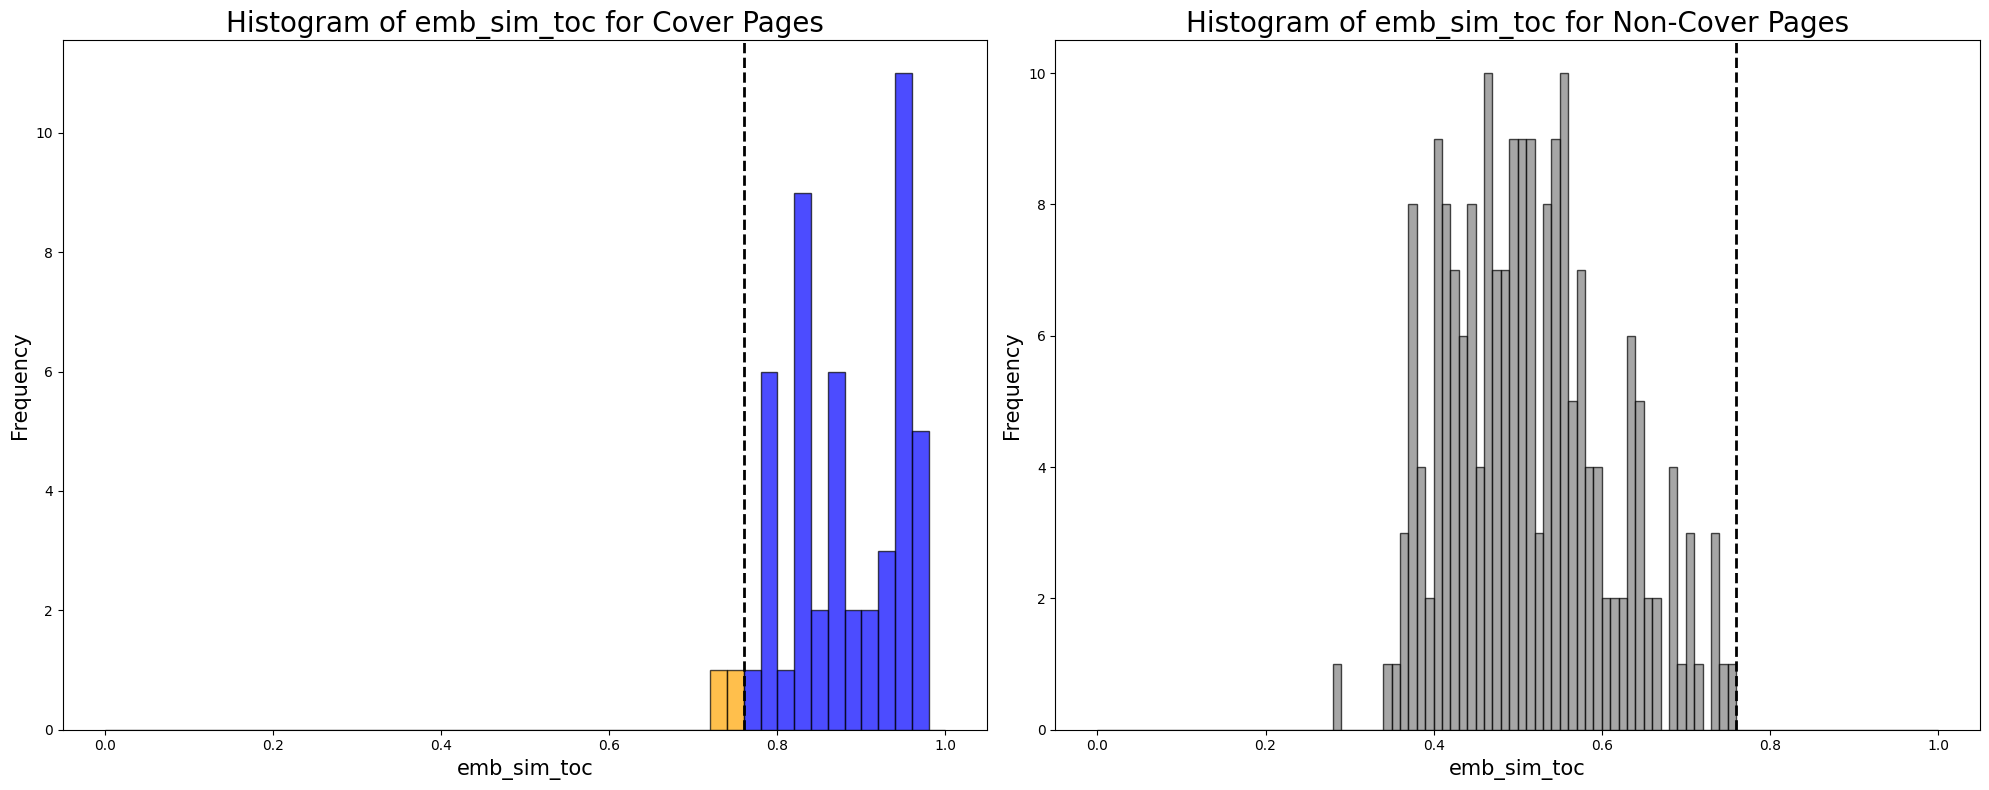

In [22]:
first_pages_test# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Filter and sort data
toc_df = first_pages_test[first_pages_test['toc'] == True].sort_values(by='emb_sim_toc')
non_toc_df = first_pages_test[first_pages_test['toc'] == False].sort_values(by='emb_sim_toc')

# Define color schemes
cover_colors = {'below': 'orange', 'above': 'blue'}
non_cover_colors = {'below': 'grey', 'above': 'red'}

# Plot for Cover Pages (cover == True)
plot_histogram(
    ax=axes[0],
    data=toc_df['emb_sim_toc'],
    threshold=threshold,
    colors=cover_colors,
    title='Histogram of emb_sim_toc for Cover Pages',
    xlabel='emb_sim_toc',
    ylabel='Frequency',
    bins=50,
    range_min=0,
    range_max=1
)

bins = 100
# Plot for Non-Cover Pages (cover == False)
plot_histogram(
    ax=axes[1],
    data=non_toc_df['emb_sim_toc'],
    threshold=threshold,
    colors=non_cover_colors,
    title='Histogram of emb_sim_toc for Non-Cover Pages',
    xlabel='emb_sim_toc',
    ylabel='Frequency',
    bins=100,
    range_min=0,
    range_max=1
)

# Adjust layout and display
plt.tight_layout()
plt.show()


### Analyse False Positives

In [23]:
for  i, p in first_pages_test[(first_pages_test['toc'] == False)&(first_pages_test['emb_sim_toc']>=threshold)].iterrows():
    print(i)
    print(p['clean_text'])
    print()
    print(p['masked_text'])
    print('-------------------')

### Analize False Negatives

In [24]:
for  i, p in first_pages_test[(first_pages_test['toc'] == True)&(first_pages_test['emb_sim_toc']<threshold)].iterrows():
    print(i)
    print(p['clean_text'])
    print()
    print(p['masked_text'])
    print('-------------------')

56
table of contents
(continued)
part iv
item 15 exhibits and financial statement schedules 90
signatures 94
ford motor company and subsidiaries financial statements
report of independent registered public accounting firm fs 1 consolidated income statement fs 2 consolidated statement of comprehensive income fs 2 sector income statement fs 3 consolidated balance sheet fs 4 sector balance sheet fs 5 condensed consolidated statement of cash flows fs 6 condensed sector statement of cash flows fs 7
consolidated statement of equity fs 8
notes to the financial statements fs 9
schedule ii — valuation and qualifying accounts fss 1
ii

table contents continued part iv item 15 exhibits financial statement schedules 90 signatures 94 ford motor company subsidiaries financial statements report independent registered public accounting firm fs 1 consolidated income statement fs 2 consolidated statement comprehensive income fs 2 sector income statement fs 3 consolidated balance sheet fs 4 sector balanc

# LLM

In [25]:
import os
from typing import Any, Dict

from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage, AIMessage

from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser



In [26]:
class DetectionAnswerToc(BaseModel):
    reasoning: str = Field(..., description="the reasoning behind your decision, including if the page is a TOC and if it is only a fraction of the TOC")
    result: bool = Field(..., description="True if the page is a TOC or a fraction of it, False otherwise")
    

parser_toc = PydanticOutputParser(pydantic_object=DetectionAnswerToc)

class DetectionAnswerCover(BaseModel):
    reasoning: str = Field(..., description="the reasoning behind your decision, including if the page is a TOC and if it is only a fraction of the TOC")
    result: bool = Field(..., description="True if the page is a cover page or a fraction of it, False otherwise")
    

parser_cover = PydanticOutputParser(pydantic_object=DetectionAnswerCover)




## Table of Content

In [27]:
# SYSTEM PROMPT

extract_toc_system = """You are an assistans specialized in Table of Contents (TOC) detection from SEC 10-K filings.

Your task is to reason about the input and detect if a provided page is a Table of Contents page or not.

To help you with your task the page text have been clean and numbers and years masked.
Here is a reference Table of Contents page:

'''table of contents
item page number
part i
item 1 business [number]
item 1a risk factors [number]
item 1b unresolved staff comments [number]
item 1c cybersecurity [number]
item 2 properties [number]
item 3 legal proceedings [number]
item 4 mine safety disclosures [number]
part ii
item 5 market for registrant’s common equity, related stockholder matters and issuer purchases of equity securities [number]
item 6 selected financial data [number]
item 7 management’s discussion and analysis of financial condition and results of operations [number]
item 7a quantitative and qualitative disclosures about market risk [number]
item 8 financial statements and supplementary data [number]
item 9 changes in and disagreements with accountants on accounting and financial disclosure [number]
item 9a controls and procedures [number]
item 9b other information [number]
item 9c disclosure regarding foreign jurisdictions that prevent inspections [number]
part iii
item 10 directors, executive officers and corporate governance [number]
item 11 executive compensation [number]
item 12 security ownership of certain beneficial owners and management and related stockholder matters [number]
item 13 certain relationships and related transactions, and director independence [number]
item 14 principal accounting fees and services [number]
part iv
item 15 exhibits, financial statement schedules [number]
signatures [number] 
item 16 form 10-k summary [number]'''

These references are indicative; the actual text may vary slightly (company name, plurals, minor wording differences) but should remain easily recognizable as the item heading.

Important notes:
The table of contents may omit some of the item headings.
The table of contents may include other sub headings.
The table of content may be splitted in multiple pages, and only a fraction of the table may be present in the page.
The table of content may have other text block at the beginning or at the end of the page, including forward looking statements, some notes, or diclaimers. 

A common false positive (that should not be detected) is the first page where Item 1 is the headings followed by its narrative text.

You will be provided with the entire page text.

"""

In [28]:
first_pages_test['llm_toc'] = False

for document in tqdm(first_pages_test['doc_id'].unique()):
    print(f"Document ID: {document}")
    print()

    sys_messge = (SystemMessage(content=extract_toc_system + "\n" + parser_toc.get_format_instructions()))

    messages = [sys_messge]

    llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
    llm = llm.with_structured_output(DetectionAnswerToc)
        
    is_last_true = False
    any_detection = False

    for _, row in first_pages_test[first_pages_test['doc_id'] == document].iterrows():
        n = row['page_number']
        page = row['masked_text']

        if is_last_true:
            human_message = f'Previous page was a toc or a fraction of it. Is the following page the continuation of the Table of Contents? \n\n{page}'
        else:
            human_message = f'Is the following page a Table of Content or the first part of a toc? \n\n{page}'

        messages.append(HumanMessage(content=human_message))     
        response = llm.invoke(messages)

        if is_last_true and not response.result:
            print(f"Page {n} is not a TOC. Eearly stop")
            print(response.reasoning)
            print()
            break

        if response.result:
            ai_message = f'Previous page is a ToC or a frament of it. \n\nPrevious reasoning: {response.reasoning}'
            messages.append(AIMessage(content=ai_message))
            is_last_true = True
            any_detection = True
            first_pages_test.loc[(first_pages_test['doc_id'] == document) & (first_pages_test['page_number'] == n), 'llm_toc'] = True

            print(f"Page {n} is a TOC")
            print(response.reasoning)
            print()
        else:
            print(f"Page {n} is not a TOC")
            print(response.reasoning)
            print()
    if not any_detection:
        print("No TOC detected")

    print('~~~~~~~~~~~~~~~~~~~~')
    # for m in messages:
    #     print(type(m))
    #     print(m.content)
    #     print()
    print('-------------------')

  0%|          | 0/50 [00:00<?, ?it/s]

Document ID: ts00_0000004127_0000004127-13-000056

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure of a 10-K filing TOC. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is identified as a complete TOC.



  2%|▏         | 1/50 [00:03<03:04,  3.77s/it]

Page 2 is not a TOC. Eearly stop
The page contains a cautionary statement regarding forward-looking statements, which is typical in annual reports but does not include any item headings or page numbers that would indicate it is a continuation of the Table of Contents (TOC). The content is primarily narrative and does not resemble the structured format of a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts01_0000004127_0000004127-18-000046

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, along with their page numbers. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Contents.



  4%|▍         | 2/50 [00:06<02:37,  3.28s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy cautionary statement regarding forward-looking statements, which is typical in annual reports but does not include any items or page numbers that would indicate it is a continuation of the Table of Contents (TOC). There are no references to specific items or sections that were listed in the previous TOC. Therefore, this page does not appear to be a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts02_0000004447_0001628280-22-004524

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts following the items, which further supports that this is a TOC rather than the beginning of a section. Therefore, this page is a complete Table of Conten

  6%|▌         | 3/50 [00:10<02:37,  3.36s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy cautionary note regarding forward-looking statements, which is typical for SEC filings but does not include any items or page numbers that would indicate it is a continuation of the Table of Contents (TOC). The absence of TOC structure, such as item headings and corresponding page numbers, suggests that this page is not part of the TOC. Instead, it appears to be a narrative section that follows the TOC, likely providing disclaimers or cautionary statements about forward-looking information.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts03_0000010456_0001193125-14-061654

Page 1 is a TOC
The page contains a list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple items from different parts, such as 'item 1 business', 'item 1a risk factors', and so on, indicating that it is indeed a TOC. There are no narrative texts or descriptions following the it

  8%|▊         | 4/50 [00:14<02:45,  3.59s/it]

Page 2 is not a TOC. Eearly stop
The page contains a detailed narrative text that describes the business operations, products, and segments of Baxter International Inc. This text is not characteristic of a Table of Contents (TOC), which typically consists of item headings and corresponding page numbers without extensive descriptions. The previous page was identified as a TOC, but this page does not continue that format and instead provides detailed information about the company, indicating that it is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts04_0000010456_0001628280-22-003432

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple items from different parts, such as 'item 1 business', 'item 2 properties', and 'item 15 exhibits', indicating that it is not just the first part of a TOC but rather a complete TOC. There are n

 10%|█         | 5/50 [00:18<02:59,  3.99s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains detailed narrative text that describes the business overview of Baxter International Inc., including information about its products, operations, and the impact of COVID-19 on its business. This text is characteristic of the main content of a 10-K filing, specifically the narrative that follows the Table of Contents. It does not contain any item headings or page numbers that would indicate it is a continuation of the Table of Contents. Therefore, this page is not a continuation of the TOC but rather the beginning of the narrative section of the filing.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts05_0000018230_0000018230-19-000034

Page 1 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). Instead, it appears to be a section related to the registrant's filing status, including checkboxes for filer status and information about stock and documents incorporated by reference. T

 12%|█▏        | 6/50 [00:23<03:13,  4.39s/it]

Page 3 is not a TOC. Eearly stop
The page contains detailed narrative text that appears to be part of the business description, specifically related to Item 1 of the 10-K filing. It does not contain any item headings or page numbers that would indicate it is a continuation of the Table of Contents. Instead, it seems to be the beginning of the actual content following the TOC, which typically starts with Item 1. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts06_0000021076_0001206774-14-002682

Page 1 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). Instead, it appears to be a narrative text discussing various regulatory filings and requirements, including details about the registrant's status and stock information. There are no item headings or page numbers typically found in a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 is a TOC
The page contains a clea

 14%|█▍        | 7/50 [00:29<03:23,  4.72s/it]

Page 3 is not a TOC. Eearly stop
The page does not contain any item headings or page numbers that are characteristic of a Table of Contents. Instead, it includes forward-looking statements and general information about the annual report, which is not part of a TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts07_0000024545_0000024545-20-000005

Page 2 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (I, II, III, IV) and various items related to business, risk factors, financial data, and governance, which aligns with the structure of a typical TOC. There are no narrative texts following the items, indicating that this is not the first page of a narrative section but rather a complete TOC. Therefore, this page is a Table of Contents.



 16%|█▌        | 8/50 [00:40<04:37,  6.62s/it]

Page 3 is not a TOC. Eearly stop
The page contains a glossary of terms and abbreviations, which is typically found in a 10-K filing but does not represent a continuation of the Table of Contents (TOC). The previous page was a TOC, but this page does not list any items or page numbers related to the TOC structure. Instead, it provides definitions and explanations of terms, indicating that it is not part of the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts08_ 0000033185_0000033185-19-000007

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with typical 10-K filing structures. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Contents.



 18%|█▊        | 9/50 [00:44<04:01,  5.88s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains detailed narrative text that describes the business operations and services of Equifax Inc. This text does not resemble a Table of Contents (TOC) format, which typically consists of item headings and corresponding page numbers. Instead, it appears to be the beginning of a section, likely Item 1, which is common in 10-K filings. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts09_0000032604_0000032604-17-000046

Page 1 is not a TOC
The page does not contain any recognizable items or headings typically found in a Table of Contents (TOC) such as 'Item 1', 'Item 2', etc. Instead, it includes information about the registrant's filing status and other details that are not part of a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 is not a TOC
The page contains detailed narrative text that describes the business operations of the company, including segm

 20%|██        | 10/50 [00:57<05:26,  8.17s/it]

Page 5 is not a TOC
The page contains detailed descriptions of various business segments and their products, specifically focusing on the commercial and residential solutions offered by the company. It does not present a structured list of items with corresponding page numbers, which is characteristic of a Table of Contents. Instead, it appears to be a narrative section that follows the introductory items of the 10-K filing, likely detailing the company's operations and offerings. Therefore, this page is not a Table of Contents or a part of it.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts10_0001751788_0001751788-20-000007

Page 1 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). Instead, it appears to be a narrative text related to the registrant's filings and disclosures, including details about the company and its stock. There are no item headings or page numbers typically found in a TOC. Therefore, this page i

 22%|██▏       | 11/50 [01:05<05:18,  8.17s/it]

Page 3 is not a TOC. Eearly stop
The page does not contain any structured list of items or page numbers that would indicate it is a continuation of the Table of Contents (TOC). Instead, it appears to be a narrative text discussing various aspects of the company, its subsidiaries, and forward-looking statements. There are no references to 'item' or 'part' headings that are characteristic of a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts11_0000037996_0000037996-14-000010

Page 1 is not a TOC
The provided text 'exhibit index begins page 90' does not contain any recognizable item headings or structure typical of a Table of Contents. It appears to reference an index rather than listing items and their corresponding page numbers. Therefore, this page is not a Table of Contents or a fraction of it.

Page 2 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characterist

 24%|██▍       | 12/50 [01:14<05:16,  8.33s/it]

Page 4 is not a TOC. Eearly stop
The page contains detailed narrative text that describes the business operations of Ford Motor Company, including historical information, corporate governance, and other disclosures. This text appears to be the beginning of Item 1 (Business) rather than a continuation of the Table of Contents (TOC). The presence of extensive narrative content indicates that this is not part of the TOC, but rather the actual content that follows the TOC in the 10-K filing.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts12_0000049196_0000049196-16-000032

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items, such as 'item 1 business', 'item 1a risk factors', and so on, along with their respective page numbers. Although there are additional headings like 'introduction' and 'executive overview', the presence of the itemized list 

 26%|██▌       | 13/50 [01:21<04:53,  7.92s/it]

Page 3 is not a TOC. Eearly stop
The page contains a glossary of acronyms and terms, which is not part of the Table of Contents (TOC). While it may be related to the document's content, it does not follow the structured item and page number format typical of a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts13_ 0000049826_0000049826-13-000007

Page 1 is not a TOC
The page provided does not contain a Table of Contents (TOC) but rather appears to be the narrative text for Item 1, which discusses the business of Illinois Tool Works Inc. A TOC typically lists items and their corresponding page numbers, while this text provides detailed information about the company's operations and segments. Therefore, this page is not a TOC or a fraction of it.

Page 2 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). Instead, it appears to be a narrative description of various business segmen

 28%|██▊       | 14/50 [01:31<05:11,  8.64s/it]

Page 5 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). It appears to be a narrative section discussing various aspects of the company's business segments, competitive advantages, and operational details. There are no item headings or page numbers typically found in a TOC. Therefore, this page is not a TOC or a part of one.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts14_140000049826_0000049826-17-000022

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Contents.



 30%|███       | 15/50 [01:35<04:13,  7.25s/it]

Page 2 is not a TOC. Eearly stop
The page provided does not contain any elements that are characteristic of a Table of Contents (TOC). Instead, it appears to be the beginning of a narrative section, specifically detailing the business and operations of Illinois Tool Works Inc. The text includes descriptions of the company's segments and operations, which is typical of the content found in the main body of a 10-K filing rather than a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts15_0000052988_0000052988-13-000140

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items that align with the typical structure found in SEC 10-K filings. The presence of 'part' and 'item' headings, along with page numbers, indicates that this is indeed a TOC. There is no indication that this is only a fra

 32%|███▏      | 16/50 [01:41<03:46,  6.66s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of text that appears to be narrative content rather than a continuation of the Table of Contents (TOC). It includes forward-looking statements and detailed descriptions of the company's business and services, which are typically found in the main body of the 10-K filing rather than in the TOC. The presence of detailed information about the company and its operations suggests that this is not a continuation of the TOC, but rather the beginning of the narrative sections of the report.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts16_0000059478_0000059478-22-000068

Page 1 is a TOC
The page contains a comprehensive list of items typically found in a Table of Contents for a 10-K filing, including multiple parts and item headings with corresponding page numbers. It does not appear to be the first part of a TOC, as it includes a complete listing of items across multiple sections. Therefore, this page qualifies

 34%|███▍      | 17/50 [01:45<03:13,  5.87s/it]

Page 2 is not a TOC. Eearly stop
The page contains a detailed discussion of forward-looking statements, which is typically not part of a Table of Contents. It does not include any item headings or page numbers that would indicate it is a continuation of the Table of Contents. Instead, it appears to be a narrative section that follows the TOC, likely providing disclaimers or additional information. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts17_0000062709_0000062709-23-000014

Page 1 is not a TOC
The page contains a lengthy discussion about forward-looking statements and various risks associated with them, but it does not present any structured list of items or page numbers that would typically be found in a Table of Contents (TOC). There are no headings or item numbers that indicate it is a TOC or a part of one. Therefore, this page is not a TOC or a fraction of a TOC.

Page 2 is a TOC
The page contains a

 36%|███▌      | 18/50 [01:51<03:10,  5.94s/it]

Page 3 is not a TOC. Eearly stop
The page does not contain a structured list of items and page numbers typical of a Table of Contents (TOC). Instead, it presents detailed narrative text about the company's business segments and operations, which is characteristic of the main content of the 10-K filing. This indicates that the page is not a continuation of the TOC but rather part of the main report, specifically the narrative section following the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts18_0000063908_0000063908-22-000011

Page 1 is a TOC
The page contains a list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes headings such as 'business summary', 'management discussion analysis', 'risk factors', and 'legal proceedings', which are typical sections found in a 10-K filing. However, it does not follow the exact format of a traditional TOC, as it includes additional text and does not clearly delineate parts

 38%|███▊      | 19/50 [01:55<02:48,  5.43s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that discusses forward-looking statements and provides detailed information about the company's business operations, structure, and franchising model. This text does not resemble a Table of Contents (TOC) format, which typically consists of item headings and corresponding page numbers. Instead, it appears to be part of the main content of the 10-K filing rather than a continuation of the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts19_0000077360_0000077360-19-000006

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the

 40%|████      | 20/50 [01:59<02:33,  5.11s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains narrative text that describes the business operations and history of Pentair PLC, which is characteristic of the main content of a 10-K filing. It does not contain any item headings or page numbers that would indicate it is a continuation of the Table of Contents (TOC). Instead, it appears to be the beginning of Item 1, which is typically the first substantive section of the 10-K report. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts20_0000078003_0000078003-16-000077

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. The presence of 'item' headings followed by page numbers further supports this classification. Additionally, t

 42%|████▏     | 21/50 [02:06<02:45,  5.72s/it]

Page 2 is not a TOC. Eearly stop
The page contains a list of defined terms and acronyms related to the company and its operations, which is typically found in the sections following the Table of Contents. However, it does not include any item headings or page numbers that would indicate it is a continuation of the Table of Contents. Instead, it appears to be a glossary or definitions section, which is separate from the TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts21_0000079282_0000079282-16-000034

Page 2 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items typically found in a 10-K filing. The presence of item headings and page numbers indicates that this is indeed a TOC, and it appears to be complete rather than just a fract

 44%|████▍     | 22/50 [02:10<02:25,  5.21s/it]

Page 3 is not a TOC. Eearly stop
The page contains a detailed discussion about forward-looking statements and various risks associated with them, which is typically found in the narrative sections of a 10-K filing rather than in a Table of Contents (TOC). The content does not include any item headings or page numbers that would indicate it is a continuation of the TOC. Instead, it appears to be part of the narrative following the TOC, specifically addressing risk factors and forward-looking statements. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts22_0000089800_0000089800-13-000046

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. Additionally, it does not appear to be the first page of

 46%|████▌     | 23/50 [02:15<02:12,  4.91s/it]

Page 2 is not a TOC. Eearly stop
The page contains detailed narrative text that describes the business operations of Sherwin-Williams Company, including information about its segments and financial performance. This text appears to be part of the narrative section that follows the Table of Contents, specifically detailing Item 1 (Business). Since it does not contain any item headings or page numbers typical of a Table of Contents, it is not a continuation of the TOC but rather the beginning of the actual content of the 10-K filing.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts23_0000091419_0001193125-15-235197

Page 1 is not a TOC
The provided text does not contain any recognizable elements of a Table of Contents (TOC). Instead, it appears to be a narrative section discussing filing requirements and disclosures related to the registrant. There are no item headings or page numbers typically found in a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 is not

 48%|████▊     | 24/50 [02:24<02:43,  6.27s/it]

Page 5 is not a TOC
The page contains detailed narrative text about the company's business segments, products, and market competition. It does not present a structured list of items or sections typically found in a Table of Contents. Therefore, it is not a Table of Contents or a part of one.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts24_0000100493_0000100493-15-000109

Page 1 is a TOC
The page contains a list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with typical TOC formats found in SEC filings. Although there is some narrative text at the beginning, the presence of the TOC structure indicates that this page is indeed a Table of Contents, and it appears to be a complete TOC rather than just a fraction of it.



 50%|█████     | 25/50 [02:29<02:25,  5.81s/it]

Page 2 is not a TOC. Eearly stop
The page contains detailed narrative text that describes the business operations of the company, specifically focusing on the segments of the business and their respective activities. This text appears to be part of the main narrative of the 10-K filing rather than a continuation of the Table of Contents (TOC). The TOC typically consists of item headings and page numbers, while this page provides in-depth information about the company's business, which is characteristic of the main body of the report. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts25_0000105770_0000105770-15-000007

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (part i, part ii, part iii, part iv) and various items under each part, indicating that it is indeed a TOC. There are no narrative t

 52%|█████▏    | 26/50 [02:34<02:15,  5.67s/it]

Page 2 is not a TOC. Eearly stop
The page provided does not contain any structured list of items or page numbers that would indicate it is a continuation of a Table of Contents (TOC). Instead, it appears to contain narrative text related to the business operations and descriptions of the company, which is typical of the main content sections of a 10-K filing. There are no headings or item numbers that align with the format of a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts26_0000106535_0000106535-13-000011

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes references to various items such as 'item 1 business', 'item 1a risk factors', and 'item 2 properties', along with their respective page numbers. The presence of multiple items and sub-items suggests that this page is indeed a TOC, and it appears to 

 54%|█████▍    | 27/50 [02:42<02:23,  6.25s/it]

Page 3 is not a TOC. Eearly stop
The page contains narrative text that describes the business operations, financial information, and other details about the company, which is typical of the main content of a 10-K filing. It does not contain a structured list of items and page numbers that would indicate it is a continuation of the Table of Contents (TOC). Instead, it appears to be part of the actual report rather than a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts27_0000310158_0001628280-24-006850

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are also some additional text blocks that appear to be part of the TOC structure, but they do not detract from its overall cla

 56%|█████▌    | 28/50 [02:49<02:21,  6.44s/it]

Page 2 is not a TOC. Eearly stop
The page contains detailed narrative text about the company's business operations, including descriptions of its pharmaceutical and animal health segments, as well as financial data. This text does not resemble a Table of Contents (TOC) format, which typically includes item headings and corresponding page numbers. Instead, it appears to be a continuation of the narrative following the TOC, rather than a continuation of the TOC itself. Therefore, this page is not a TOC or a fraction of it.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts28_0000315293_0001628280-17-001652

Page 1 is a TOC
The page contains a comprehensive list of items typically found in a Table of Contents, including multiple parts and item headings. It does not appear to be the first page of a narrative section, as it lists various items and sub-items in a structured manner. Therefore, this page can be classified as a Table of Contents, and it seems to include the entirety of t

 58%|█████▊    | 29/50 [02:52<01:58,  5.62s/it]

Page 2 is not a TOC. Eearly stop
The page contains detailed narrative text that describes the business overview of Aon plc, including its operations, services, and financial information. This text does not resemble a Table of Contents, which typically consists of item headings and page numbers. Instead, it appears to be part of the main body of the 10-K filing, specifically the narrative section following the Table of Contents. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts29_0000319201_0000319201-18-000045

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items typically found in a 10-K filing. Although there is a mention of a 'special note regarding forward looking statements' at the beginning, this does not detract from the 

 60%|██████    | 30/50 [02:57<01:44,  5.23s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy discussion about forward-looking statements, which is typically found in the narrative sections of a 10-K filing rather than in a Table of Contents (TOC). There are no item headings or page numbers listed that would indicate this is a continuation of the TOC. Instead, it appears to be a detailed explanation of forward-looking statements, which is not characteristic of a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts30_0000711404_0000711404-14-000017

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure of a 10-K filing. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is a complete Ta

 62%|██████▏   | 31/50 [03:00<01:27,  4.60s/it]

Page 2 is not a TOC. Eearly stop
The page contains a detailed forward-looking statement section, which is typically not part of a Table of Contents (TOC). The content is focused on discussing risks and uncertainties related to future performance, rather than listing items and their corresponding page numbers. This indicates that the page is not a continuation of the TOC, but rather a separate section of the 10-K filing.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts31_0000715957_0001193125-17-060413

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a section. Therefore, this page is a complete Table of Contents.



 64%|██████▍   | 32/50 [03:04<01:20,  4.48s/it]

Page 2 is not a TOC. Eearly stop
The page contains a glossary of terms and definitions, which is not typical for a Table of Contents (TOC). A TOC usually lists sections and their corresponding page numbers, while this page focuses on abbreviations and acronyms used in the document. Therefore, this page does not appear to be a continuation of the TOC, but rather a separate section dedicated to definitions and explanations.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts32_0000715957_0001564590-21-008442

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. The presence of item headings and page numbers suggests that this page is a complete TOC rather than just a fraction of it.



 66%|██████▌   | 33/50 [03:07<01:10,  4.13s/it]

Page 2 is not a TOC. Eearly stop
The page contains a glossary of terms and definitions, which is not part of a Table of Contents (TOC). A TOC typically lists sections and their corresponding page numbers, while this page focuses on explaining abbreviations and acronyms used in the document. Therefore, this page does not continue the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts33_0000723254_0000723254-23-000025

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Contents.



 68%|██████▊   | 34/50 [03:12<01:07,  4.21s/it]

Page 2 is not a TOC. Eearly stop
The page contains detailed narrative text that describes the business operations of Cintas Corporation, including information about its products, services, and financial segments. This is not characteristic of a Table of Contents (TOC), which typically lists items and their corresponding page numbers without detailed descriptions. Therefore, this page is not a continuation of the TOC but rather the beginning of the narrative section, specifically Item 1, which is the business overview.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts34_0000732717_0000732717-18-000009

Page 1 is not a TOC
The provided text does not contain any recognizable item headings or page numbers typically found in a Table of Contents (TOC). Instead, it appears to reference documents and meetings related to the company, which is not characteristic of a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 is not a TOC
The page does not contain any recognizabl

 70%|███████   | 35/50 [03:21<01:26,  5.76s/it]

Page 5 is not a TOC. Eearly stop
The page contains detailed narrative text that appears to be part of the business description and operational details of the company. It does not contain any structured list of items or page numbers that would indicate it is a continuation of a Table of Contents (TOC). Instead, it seems to be the beginning of the actual content of the 10-K filing, specifically related to the business operations and history of the company. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts35_0000740260_0000740260-22-000057

Page 1 is not a TOC
The page does not contain any recognizable item headings or a structured list that resembles a Table of Contents. Instead, it appears to reference other documents and sections without providing a clear outline of items typically found in a TOC. Therefore, this page is not a Table of Contents or a part of it.

Page 2 is not a TOC
The provided text does not contain any rec

 72%|███████▏  | 36/50 [03:30<01:33,  6.70s/it]

Page 5 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes references to various parts and items typically found in a 10-K filing, such as 'business', 'risk factors', 'properties', and 'financial statements'. The format and content align closely with what is expected in a TOC, indicating that this page is indeed a Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts36_0000753308_0000753308-16-000337

Page 1 is not a TOC
The page contains a list of definitions and acronyms, which is not typical for a Table of Contents (TOC). A TOC usually includes item headings and page numbers related to the structure of the document, such as sections and subsections. This page does not present any of the expected TOC format or item headings, and instead focuses on definitions and terms. Therefore, it is not a TOC or a fraction of a TOC.

Page 2 is a TOC
The page contains a 

 74%|███████▍  | 37/50 [03:37<01:29,  6.91s/it]

Page 3 is not a TOC. Eearly stop
The page contains detailed narrative text that appears to be the beginning of Item 1, which is typically the first item following the Table of Contents in a 10-K filing. This text discusses the business overview of Nextera Energy Inc. and includes specific details about its operations, capacity, and subsidiaries. Since this text is not part of the Table of Contents and instead represents the actual content of Item 1, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts37_0000764180_0000764180-22-000019

Page 1 is not a TOC
The page contains a list of definitions and acronyms, which is not typical for a Table of Contents (TOC). A TOC usually includes item headings and page numbers related to the structure of the document, such as sections and subsections. This page does not present any of the expected TOC format or item headings, and instead focuses on definitions and terms. Therefore, it is 

 76%|███████▌  | 38/50 [03:44<01:20,  6.67s/it]

Page 3 is not a TOC. Eearly stop
The page contains detailed narrative text that appears to be the beginning of Item 1, which is typically the first item following the Table of Contents in a 10-K filing. This text discusses the business overview of Nextera Energy Inc. and includes specific details about its operations, capacity, and subsidiaries. Since this is a narrative section rather than a list of items with page numbers, it does not represent a continuation of the Table of Contents. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts38_0000765880_0001558370-15-000067

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items, such as 'part 3', 'item 1 business', 'item 1a risk factors', and so on, along with their respective page numbers. There is no narrative text following the items, which f

 78%|███████▊  | 39/50 [03:47<01:03,  5.76s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy narrative text that discusses forward-looking statements and various risks associated with the company. This text does not resemble a Table of Contents (TOC) format, which typically includes a structured list of items and their corresponding page numbers. Instead, it appears to be a continuation of the narrative content rather than a continuation of the TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts39_0000766704_0000766704-21-000018

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure of a 10-K filing. There are no narrative texts or descriptions following the item headings, indicating that this is not the first page of a narrative section but rather a TOC. T

 80%|████████  | 40/50 [03:53<00:56,  5.65s/it]

Page 2 is not a TOC. Eearly stop
The page contains detailed narrative text that describes the business operations and various property types of Welltower Inc., which is characteristic of the main content of a 10-K filing rather than a Table of Contents (TOC). The presence of item headings such as 'item 1 business' suggests that this is the beginning of the narrative section following the TOC, rather than a continuation of the TOC itself. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts40_0000773840_0000930413-13-000907

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (I, II, III, IV) and various items typically found in a 10-K filing. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is a complete Tabl

 82%|████████▏ | 41/50 [03:57<00:46,  5.18s/it]

Page 2 is not a TOC. Eearly stop
The page contains detailed narrative text that describes the business operations of Honeywell International Inc., including information about its segments, products, and services. This is not characteristic of a Table of Contents (TOC), which typically lists items and their corresponding page numbers without extensive descriptions. Therefore, this page is not a continuation of the TOC but rather the beginning of a narrative section.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts41_0000779152_0000779152-18-000060

Page 1 is not a TOC
The provided text does not contain any recognizable headings or structure that would indicate it is a Table of Contents (TOC). Instead, it appears to be a narrative section discussing various regulatory filings and company information, which is typical of the introductory pages of a 10-K filing. There are no item numbers or titles that align with the standard TOC format, and it does not seem to be a fraction of a 

 84%|████████▍ | 42/50 [04:04<00:47,  5.97s/it]

Page 3 is not a TOC. Eearly stop
The page contains narrative text discussing forward-looking statements and references to risk factors, which are typical components of a 10-K filing. However, it does not contain any structured list of items or page numbers that would indicate it is a continuation of the Table of Contents (TOC). Instead, it appears to be part of the main body of the report, specifically discussing forward-looking statements and their implications. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts42_0000788784_0000788784-20-000004

Page 1 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). Instead, it appears to be a continuation of a previous page with detailed information about the registrant's filing status, issuer qualifications, and stock information. There are no item headings or page numbers typically found in a TOC. Therefore, this page is not a TOC or a frac

 86%|████████▌ | 43/50 [04:12<00:44,  6.35s/it]

Page 4 is not a TOC. Eearly stop
The page does not contain a structured list of items and their corresponding page numbers, which are characteristic of a Table of Contents (TOC). Instead, it appears to be a narrative text discussing forward-looking statements and various risks associated with the company's future performance. While it references some items from the TOC, it does not present them in a list format with page numbers, indicating that this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts43_0000789570_0001564590-15-001180

Page 1 is not a TOC
The page contains a narrative text that appears to be the beginning of Item 1, which discusses the business of MGM Resorts International. It does not present a structured list of items with corresponding page numbers, which is characteristic of a Table of Contents (TOC). Therefore, this page is not a TOC or a fraction of it, but rather the start of the detailed discussion of the business se

 88%|████████▊ | 44/50 [04:20<00:41,  6.99s/it]

Page 5 is not a TOC
The page does not contain any recognizable headings or structure typical of a Table of Contents (TOC). Instead, it appears to be a narrative section discussing marketing strategies, customer loyalty programs, and operational details of the resorts. There are no item numbers or page references that would indicate it is part of a TOC. Therefore, this page is not a TOC or a part of one.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts44_0000798354_0001628280-16-011435

Page 1 is a TOC
The page contains a comprehensive list of items typically found in a Table of Contents, including multiple parts and item headings with corresponding page numbers. It does not appear to be the first part of a TOC, as it includes a complete listing of items across several parts. Therefore, this page qualifies as a Table of Contents.



 90%|█████████ | 45/50 [04:24<00:30,  6.03s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that appears to be part of the main body of the 10-K filing, specifically starting with forward-looking statements and then transitioning into a description of the business. This indicates that it is not a continuation of the Table of Contents, but rather the beginning of the actual report. The presence of detailed information about the company and its operations further supports this conclusion.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts45_0000831259_0000831259-19-000009

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items typically found in a 10-K filing. The presence of item headings and page numbers indicates that this is indeed a TOC, rather than just the first part of it. Therefore, this page q

 92%|█████████▏| 46/50 [04:28<00:22,  5.51s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that appears to be part of the business description and risk factors, rather than a continuation of the Table of Contents (TOC). While it references 'item 1a risk factors', it does not provide a list of items or page numbers typical of a TOC. Therefore, this page does not qualify as a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts46_0000879101_0001437749-18-003230

Page 1 is not a TOC
The page does not contain a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). Instead, it includes various disclosures and information about the registrant, such as filer status and market value, which are not typical of a TOC. There are no item headings or a clear indication of a TOC format. Therefore, this page is not a TOC or a fraction of it.

Page 2 is a TOC
The page contains a structured list of items and thei

 94%|█████████▍| 47/50 [04:34<00:16,  5.47s/it]

Page 3 is not a TOC. Eearly stop
The page contains a significant amount of text that appears to be narrative content rather than a continuation of the Table of Contents (TOC). It includes forward-looking statements and detailed descriptions of the company's operations, which are not typical of a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts47_0000879101_0001437749-19-002746

Page 1 is not a TOC
The page does not contain a recognizable Table of Contents format. It includes information about the registrant, market value, shares outstanding, and references to other documents, but it lacks the structured item headings and page numbers typical of a TOC. Additionally, it appears to be part of the narrative text rather than a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table o

 96%|█████████▌| 48/50 [04:39<00:10,  5.37s/it]

Page 3 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that discusses forward-looking statements and provides detailed information about the company, its operations, and its financials. This text does not resemble a continuation of the Table of Contents (TOC) as it lacks the structured item headings and page numbers typically found in a TOC. Instead, it appears to be part of the main body of the 10-K filing, specifically related to risk factors and company information. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts48_0000879169_0001558370-20-000774

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items typically found in a 10-K filing. There are no narrative texts or descriptions that would indicate this i

 98%|█████████▊| 49/50 [04:43<00:05,  5.06s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain any items or page numbers that are characteristic of a Table of Contents (TOC). Instead, it includes a narrative text discussing forward-looking statements and various risks and uncertainties related to the company's operations and drug candidates. This indicates that the page is not a continuation of the TOC but rather a section of the 10-K filing that follows the TOC. Therefore, this page is not a TOC or a fraction of it.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts49_0000882184_0000882184-21-000190

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items, such as 'part i', 'item 1 business', 'item 1a risk factors', and so on, along with their respective page numbers. This indicates that the page is indeed a Table of Contents and not just the first part of it. The presence of 'part

100%|██████████| 50/50 [04:48<00:00,  5.76s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains detailed narrative text that describes the business operations of the company, specifically focusing on 'item 1 business'. This indicates that it is not a continuation of the Table of Contents (TOC) but rather the actual content that follows the TOC. The presence of detailed descriptions, financial data, and operational insights suggests that this is part of the main report rather than a TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------


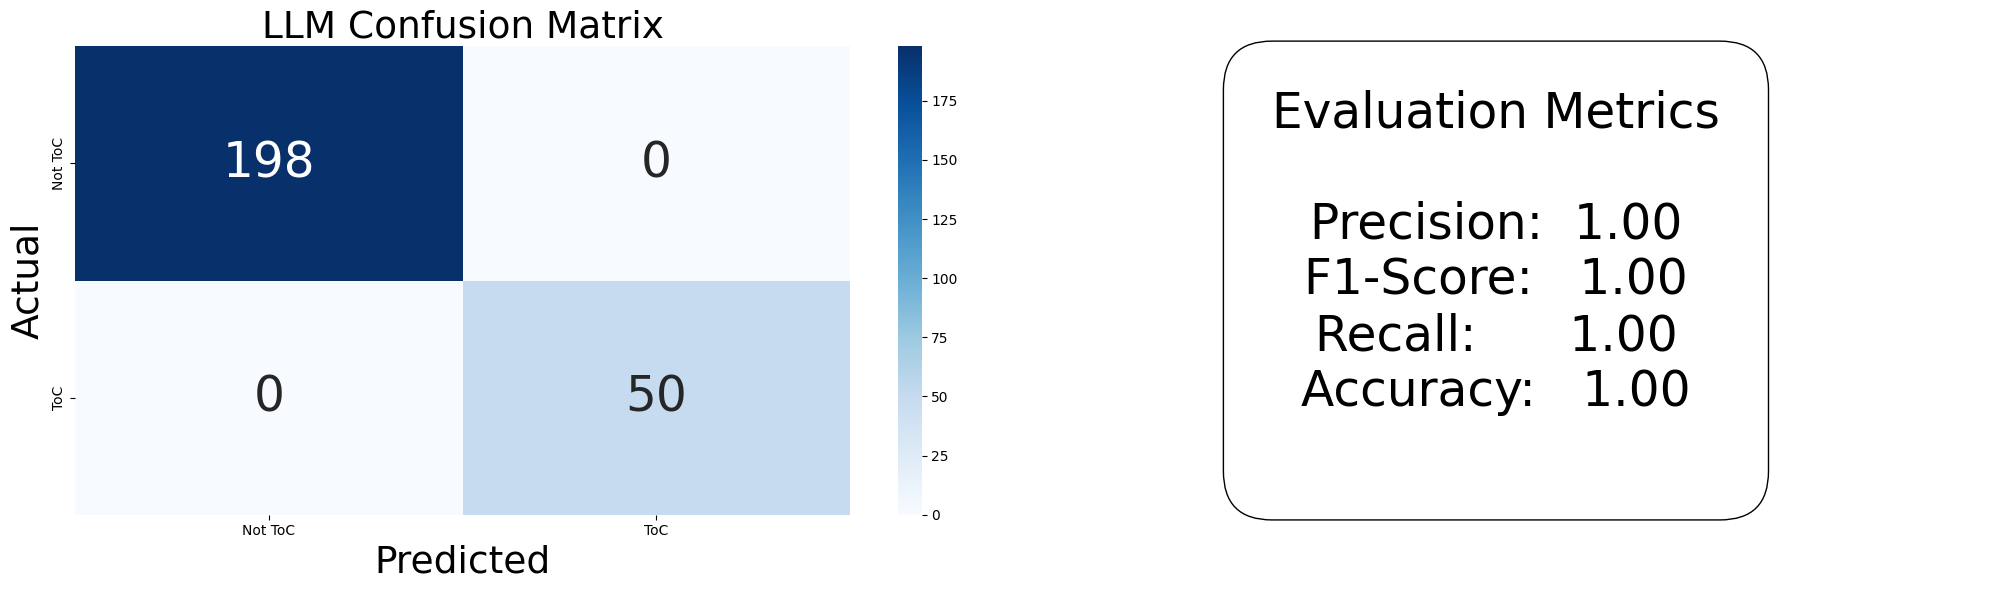

In [29]:
first_pages_test# Compute Confusion Matrix
cm = confusion_matrix(first_pages_test['toc'], first_pages_test['llm_toc'])
labels = ['Not ToC', 'ToC']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Compute Evaluation Metrics
accuracy = accuracy_score(first_pages_test['toc'], first_pages_test['llm_toc'])
precision = precision_score(first_pages_test['toc'], first_pages_test['llm_toc'], zero_division=0)
recall = recall_score(first_pages_test['toc'], first_pages_test['llm_toc'], zero_division=0)
f1 = f1_score(first_pages_test['toc'], first_pages_test['llm_toc'], zero_division=0)

metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:   {f1:.2f}\n"
    f"Recall:      {recall:.2f}\n"
    f"Accuracy:   {accuracy:.2f}\n"
)

# Set the figure size
plt.figure(figsize=(20, 6))

# Create subplots: 1 row, 2 columns
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# ----------------------------
# Left: Confusion Matrix
# ----------------------------
sns.heatmap(
    cm_df, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=ax1,
    annot_kws={"size": 35}
)
ax1.set_title('LLM Confusion Matrix', fontsize=27)
ax1.set_ylabel('Actual', fontsize=27)
ax1.set_xlabel('Predicted', fontsize=27)

# ----------------------------
# Right: Metrics Text
# ----------------------------
ax2.axis('off')  # Hide the axis

# Add the metrics text
ax2.text(
    0.5, 0.5, 
    metrics_text, 
    horizontalalignment='center', 
    verticalalignment='center', 
    fontsize=35, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### False Postives Analysis

In [30]:
for _, row in first_pages_test[(first_pages_test['llm_toc'] == True) & (first_pages_test['toc'] == False)].iterrows():
    print(row['doc_id'], 'page number:', row['page_number'])
    print(row['clean_text'])
    print()
    print(row['masked_text'])
    print('-------------------')

## Cover Page

In [31]:
# SYSTEM PROMPT

extract_cover_system = """You are an assistans specialized in Cover Page detection from SEC 10-K filings.

Your task is to reason about the input and detect if a provided page is a segment of the Cover Page or not.

To help you with your task the page text have been clean and numbers and years masked.
Here is a reference Cover Page:

'''indicate check mark whether registrant large accelerated filer accelerated filer non accelerated filer smaller reporting company emerging growth company see definitions large accelerated filer accelerated filer smaller reporting company emerging growth company rule 12b number exchange act company large accelerated filer accelerated filer non accelerated filer smaller reporting company emerging growth company check smaller reporting company emerging growth company indicate check mark registrant elected use extended transition period complying new revised financial accounting standards provided pursuant section number exchange act indicate check mark whether registrant shell company defined rule 12b number exchange act company yes dte electric yes month number year aggregate market value company voting non voting common equity held non affiliates approximately number number billion based new york stock exchange closing price date number shares common stock outstanding january number year registrant description shares company common stock without par value number number number company common stock number par value directly owned company number number number documents incorporated reference certain information company definitive proxy statement year annual meeting common shareholders held may number year filed securities exchange commission pursuant regulation 14a later number days end registrant fiscal year covered report form number k incorporated herein reference part iii items number number number number number form number k combined form number k filed separately two registrants company information contained herein relating individual registrant filed registrant solely behalf dte electric makes representation information relating exclusively company company wholly owned subsidiary company meets conditions set forth general instructions number b form number k therefore filing form reduced disclosure format specified general instruction number form number k cautionary statements unless otherwise indicated except context otherwise requires terms us company similar terms annual report form number k annual report refer ventas inc consolidated subsidiaries forward looking statements annual report includes forward looking statements within meaning section 27a securities act year amended securities act section 21e securities exchange act year amended exchange act forward looking statements include among others statements expectations beliefs future plans strategies anticipated results operations developments matters historical facts forward looking statements include among things statements regarding officers intent belief expectation identified use words assume may project expect believe intend anticipate seek target forecast plan potential opportunity estimate could would comparable derivative terms negatives thereof forward looking statements based management beliefs well number assumptions concerning future events put undue reliance forward looking statements guarantee performance subject number uncertainties factors could cause actual events results differ materially expressed implied forward looking statements undertake duty update forward looking statements speak date made urge carefully review disclosures make concerning risks uncertainties may affect business future financial performance including made summary risk factors item 1a risk factors report'''

These references are indicative; the actual text may vary slightly (company name, plurals, minor wording differences) but should remain easily recognizable as a part of a 10-K filling cover page.

Important notes:
Usually referes to stock number, market value, or filler size.
May contain a cautionary statement. However it is not mandatory, and if it is only a cautionary statement is likely not a cover page section.
If the page is a table of contents, it is not a cover page.

A common false positive (that should not pass as cover page) is the page where Item 1 is the headings followed by its narrative text.

You will be provided with the entire page text.
"""

In [32]:
first_pages_test['llm_cover'] = False

for document in tqdm(first_pages_test['doc_id'].unique()):
    print(f"Document ID: {document}")
    print()

    sys_messge = (SystemMessage(content=extract_cover_system + "\n" + parser_cover.get_format_instructions()))

    messages = [sys_messge]

    llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
    llm = llm.with_structured_output(DetectionAnswerCover)
        
    is_last_true = False
    any_detection = False

    for _, row in first_pages_test[first_pages_test['doc_id'] == document].iterrows():
        n = row['page_number']
        page = row['masked_text']

        if row['llm_toc']:
            print(f"Page {n} is a TOC. Early Exit")
            break

        if is_last_true:
            human_message = f'Previous page was segment of the cover page. Is the following page the continuation of it? \n\n{page}'
        else:
            human_message = f'Is the following page a segment of the cover page? \n\n{page}'

        messages.append(HumanMessage(content=human_message))     
        response = llm.invoke(messages)

        if is_last_true and not response.result:
            print(f"Page {n} is not a cover page. Eearly stop")
            print(response.reasoning)
            print()
            break

        if response.result:
            ai_message = f'Previous page is a cover page or a frament of it. \n\nPrevious reasoning: {response.reasoning}'
            messages.append(AIMessage(content=ai_message))
            is_last_true = True
            any_detection = True
            first_pages_test.loc[(first_pages_test['doc_id'] == document) & (first_pages_test['page_number'] == n), 'llm_cover'] = True

            print(f"Page {n} is a cover page")
            print(response.reasoning)
            print()
        else:
            print(f"Page {n} is not a cover page")
            print(response.reasoning)
            print()
    if not any_detection:
        print("No cover page detected")

    print('~~~~~~~~~~~~~~~~~~~~')
    # for m in messages:
    #     print(type(m))
    #     print(m.content)
    #     print()
    print('-------------------')

 10%|█         | 5/50 [00:00<00:01, 42.35it/s]

Document ID: ts00_0000004127_0000004127-13-000056

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts01_0000004127_0000004127-18-000046

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts02_0000004447_0001628280-22-004524

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts03_0000010456_0001193125-14-061654

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts04_0000010456_0001628280-22-003432

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts05_0000018230_0000018230-19-000034

Page 1 is a cover page
The page contains elements that are typically found on a cover page, such as check marks for filer status, market value of common stock, and references to the number of shares outstanding. However, it also inclu

 20%|██        | 10/50 [00:10<00:50,  1.26s/it]

Page 2 is not a cover page. Eearly stop
The text provided is a detailed narrative that appears to be part of Item 1, which discusses the business operations of Emerson Electric Co. It does not contain any of the typical elements found in a cover page, such as references to stock numbers, market value, or filer status. Instead, it focuses on the company's business segments and financial information, which is characteristic of the main body of a 10-K filing rather than the cover page. Therefore, this page is not a continuation of the cover page.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts10_0001751788_0001751788-20-000007



 22%|██▏       | 11/50 [00:13<00:54,  1.41s/it]

Page 1 is a cover page
The page contains several elements that are characteristic of a cover page, including check marks for registrant classifications (large accelerated filer, accelerated filer, etc.), aggregate market value of common stock, and details about shares outstanding. It does not appear to be a table of contents, and it does not solely consist of a cautionary statement. Therefore, it is reasonable to conclude that this page is a segment of the cover page.

Page 2 is a TOC. Early Exit
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts11_0000037996_0000037996-14-000010



 26%|██▌       | 13/50 [00:17<01:03,  1.72s/it]

Page 1 is not a cover page
The provided text indicates that it is an exhibit index, which is typically part of the table of contents (TOC) of a 10-K filing. Since it does not contain any information related to the cover page, such as stock numbers, market value, or filer size, and it is clearly a TOC reference, it cannot be considered a segment of the cover page.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts12_0000049196_0000049196-16-000032

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts13_ 0000049826_0000049826-13-000007

Page 1 is not a cover page
The provided text does not contain any elements typical of a cover page from a 10-K filing. It appears to be a narrative description of the company's business and its operating segments, which is characteristic of Item 1 in a 10-K report. There are no references to stock numbers, market value, or any of the specific l

 28%|██▊       | 14/50 [00:30<02:05,  3.49s/it]

Page 5 is not a cover page
The page provided contains detailed descriptions of various business segments, their competitive advantages, and operational strategies. It does not contain any information typically found on a cover page, such as stock numbers, market value, or company identifiers. Additionally, it does not include any cautionary statements or references to the filing itself. Therefore, this page is not a segment of the cover page.

No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts14_140000049826_0000049826-17-000022

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts15_0000052988_0000052988-13-000140

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts16_0000059478_0000059478-22-000068

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts17_0000062709_0000062709-23-000014



 44%|████▍     | 22/50 [00:32<00:34,  1.22s/it]

Page 1 is not a cover page
The page contains a detailed discussion of forward-looking statements, which is a common element in 10-K filings. However, it does not include any specific information about stock numbers, market value, or filer size, which are typically found on the cover page. Additionally, there is no indication that this text is part of a table of contents, nor does it appear to be a fraction of the cover page. Therefore, this page does not qualify as a segment of the cover page.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts18_0000063908_0000063908-22-000011

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts19_0000077360_0000077360-19-000006

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts20_0000078003_0000078003-16-000077

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~

 58%|█████▊    | 29/50 [00:38<00:18,  1.14it/s]

Page 2 is not a cover page. Eearly stop
The page provided contains detailed narrative text that appears to be from Item 1 (Business) of the 10-K filing. It discusses the company's history, operations, acquisitions, and product segments, which are typical contents of Item 1 rather than the cover page. Since it does not contain any elements that are characteristic of a cover page, such as check marks for registrant status or aggregate market value, it is not a continuation of the cover page.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts24_0000100493_0000100493-15-000109

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts25_0000105770_0000105770-15-000007

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts26_0000106535_0000106535-13-000011

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts27_0000310158_00016

 68%|██████▊   | 34/50 [00:38<00:08,  1.84it/s]

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts33_0000723254_0000723254-23-000025

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts34_0000732717_0000732717-18-000009

Page 1 is not a cover page
The provided text does not contain any references to stock numbers, market value, or filer size, which are typical indicators of a cover page. Additionally, it appears to reference documents and meetings rather than providing information typically found on a cover page. There are no cautionary statements or other recognizable elements of a cover page. Therefore, this page is not a segment of the cover page.

Page 2 is not a cover page
The page contains a list of securities registered under section 12(b) of the act, detailing various classes of shares and their respective exchange listings. This type of information is typically found in the body of the 10-K filing rather than on 

 68%|██████▊   | 34/50 [00:52<00:08,  1.84it/s]

Page 3 is not a cover page
The page contains extensive cautionary statements and discussions about risks, which are typical in the narrative sections of a 10-K filing, but it does not contain any of the specific elements that are characteristic of a cover page, such as stock numbers, market value, or company identifiers. Additionally, it does not appear to be a table of contents. However, it is primarily focused on risk factors and does not resemble a cover page segment.



 72%|███████▏  | 36/50 [00:55<00:27,  1.98s/it]

Page 4 is not a cover page
The provided text does not contain any elements typical of a cover page, such as stock numbers, market value, or filer size. It appears to be discussing third-party information and does not include any cautionary statements or references to the registrant's status. Additionally, it does not resemble a table of contents. Therefore, it is not a segment of the cover page.

Page 5 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts36_0000753308_0000753308-16-000337



 74%|███████▍  | 37/50 [00:56<00:24,  1.91s/it]

Page 1 is not a cover page
The provided text is a table of contents (TOC) listing definitions and acronyms used in the document. It does not contain any elements typical of a cover page, such as stock numbers, market value, or company information. Therefore, it is not a segment of the cover page.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts37_0000764180_0000764180-22-000019



 78%|███████▊  | 39/50 [00:57<00:17,  1.60s/it]

Page 1 is not a cover page
The provided text is a table of contents (TOC) listing definitions and acronyms used in the document. It does not contain any elements typical of a cover page, such as stock numbers, market value, or company descriptions. Therefore, it is not a segment of the cover page.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts38_0000765880_0001558370-15-000067

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts39_0000766704_0000766704-21-000018

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts40_0000773840_0000930413-13-000907

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts41_0000779152_0000779152-18-000060



 84%|████████▍ | 42/50 [01:00<00:10,  1.32s/it]

Page 1 is a cover page
The page contains several indicators typical of a cover page, including check marks for filer status, information about the aggregate market value of common stock, and references to the registrant's status as a shell company. It also includes details about the number of shares outstanding and the par value, which are common elements found on a cover page. There are no indications that this is a table of contents or a narrative section from Item 1. Therefore, this page is likely a segment of the cover page.

Page 2 is a TOC. Early Exit
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts42_0000788784_0000788784-20-000004

Page 1 is not a cover page
The page contains multiple references to check marks for various registrant statuses, such as large accelerated filer and emerging growth company, which are typical elements found on a cover page of a 10-K filing. It also includes information about the aggregate market value of common stock and mentions the filing r

 92%|█████████▏| 46/50 [01:13<00:07,  1.93s/it]

Page 5 is not a cover page
The provided text does not contain any elements typical of a cover page from a 10-K filing. It discusses marketing strategies, customer loyalty programs, and operational details about the resorts, which are more aligned with the business operations section rather than the cover page. There are no references to stock numbers, market value, or the typical cautionary statements found on cover pages. Additionally, it does not appear to be a table of contents, but it is clearly part of the narrative text that follows the item headings, which is not characteristic of a cover page.

No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts44_0000798354_0001628280-16-011435

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts45_0000831259_0000831259-19-000009

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts46_0000879101_0001437749-

100%|██████████| 50/50 [01:17<00:00,  1.56s/it]

Page 1 is not a cover page
The page contains elements that are typically found in a cover page, such as references to the registrant's market value and shares outstanding. However, it also includes a reference to a table of contents ('table contents') and mentions of specific dates and filings that suggest it may not be solely a cover page segment. The presence of 'table contents' indicates that this page is likely part of a larger document structure rather than a standalone cover page. Therefore, it is not a cover page or a fraction of it.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts48_0000879169_0001558370-20-000774

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: ts49_0000882184_0000882184-21-000190

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------


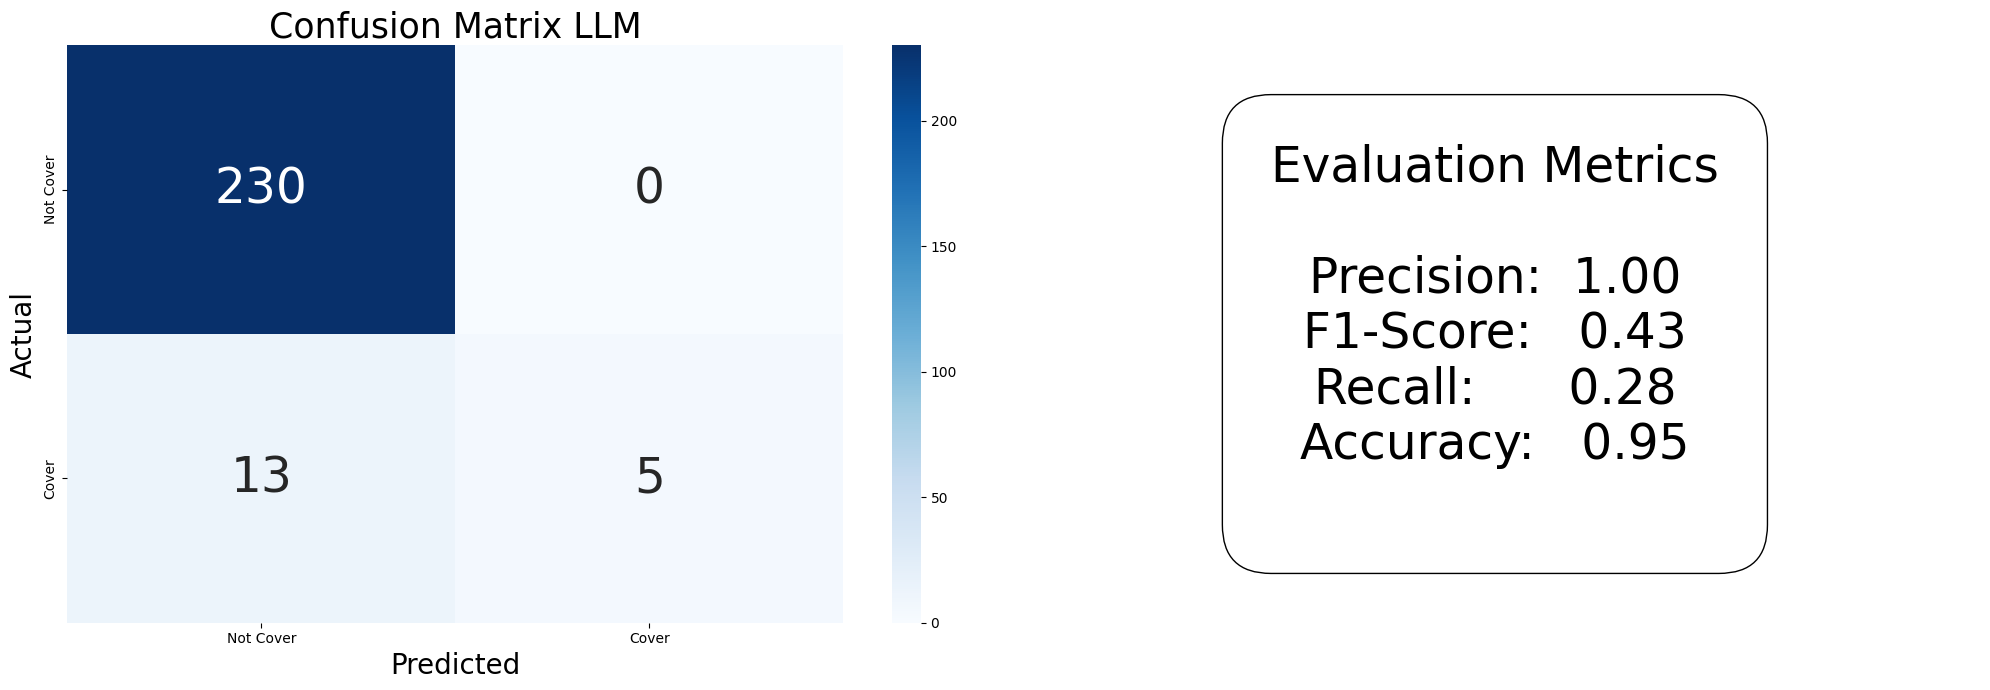

In [33]:
# Compute Confusion Matrix
cm = confusion_matrix(first_pages_test['cover'], first_pages_test['llm_cover'])
labels = ['Not Cover', 'Cover']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Compute Evaluation Metrics
accuracy = accuracy_score(first_pages_test['cover'], first_pages_test['llm_cover'])
precision = precision_score(first_pages_test['cover'], first_pages_test['llm_cover'], zero_division=0)
recall = recall_score(first_pages_test['cover'], first_pages_test['llm_cover'], zero_division=0)
f1 = f1_score(first_pages_test['cover'], first_pages_test['llm_cover'], zero_division=0)

metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:   {f1:.2f}\n"
    f"Recall:      {recall:.2f}\n"
    f"Accuracy:   {accuracy:.2f}\n"
)

# Set the figure size
plt.figure(figsize=(20, 7))

# Create subplots: 1 row, 2 columns
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# ----------------------------
# Left: Confusion Matrix
# ----------------------------
sns.heatmap(
    cm_df, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=ax1,
    annot_kws={"size": 35}
)
ax1.set_title('Confusion Matrix LLM', fontsize=25)
ax1.set_ylabel('Actual', fontsize=20)
ax1.set_xlabel('Predicted', fontsize=20)

# ----------------------------
# Right: Metrics Text
# ----------------------------
ax2.axis('off')  # Hide the axis

# Add the metrics text
ax2.text(
    0.5, 0.5, 
    metrics_text, 
    horizontalalignment='center', 
    verticalalignment='center', 
    fontsize=35, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
)
    

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# Update Dfs


In [34]:
for file_name in file_names:
    toc_pages = first_pages_test[(first_pages_test['doc_id'] == file_name)&(first_pages_test['llm_toc'])]['page_number'].to_list()

    if toc_pages:
        # cover_pages = all numbers from 1 to the min of toc pages (excluded)
        cover_pages = list(range(1, min(toc_pages)))
    else:
        cover_pages = first_pages_test[(first_pages_test['doc_id'] == file_name)&(first_pages_test['emb_sim_cover']>=tcp)]['page_number'].to_list()
    print('Document:', file_name)
    print('ToC pages:', toc_pages)
    print('Cover pages:', cover_pages)
    print()

    df = pd.read_parquet(f'outputs/test/{file_name}/initial_df.parquet')
    if toc_pages:
        # where page number is in toc_pages chante is_noise to True and noise_type to 'toc'
        df.loc[df['page_number'].isin(toc_pages), 'is_noise'] = True
        df.loc[df['page_number'].isin(toc_pages), 'noise_type'] = 'toc'
    if cover_pages:
        # where page number is in cover_pages chante is_noise to True and noise_type to 'cover'
        df.loc[df['page_number'].isin(cover_pages), 'is_noise'] = True
        df.loc[df['page_number'].isin(cover_pages), 'noise_type'] = 'cover'

    # where page_numner = 0 cover page
    df.loc[df['page_number'] == 0, 'is_noise'] = True
    df.loc[df['page_number'] == 0, 'noise_type'] = 'cover'

    # if a page has a detected_page_number, all row with the same page_number must have the detected_page_number equal to that one
    detected_page_numbers = df.groupby('page_number')['detected_page_number'].first()
    # Map the detected_page_number back to the original DataFrame
    df['detected_page_number'] = df['page_number'].map(detected_page_numbers)


    df.to_parquet(f'outputs/test/{file_name}/df_toc.parquet')


Document: ts00_0000004127_0000004127-13-000056
ToC pages: [1]
Cover pages: []

Document: ts01_0000004127_0000004127-18-000046
ToC pages: [1]
Cover pages: []

Document: ts02_0000004447_0001628280-22-004524
ToC pages: [1]
Cover pages: []

Document: ts03_0000010456_0001193125-14-061654
ToC pages: [1]
Cover pages: []

Document: ts04_0000010456_0001628280-22-003432
ToC pages: [1]
Cover pages: []

Document: ts05_0000018230_0000018230-19-000034
ToC pages: [2]
Cover pages: [1]

Document: ts06_0000021076_0001206774-14-002682
ToC pages: [2]
Cover pages: [1]

Document: ts07_0000024545_0000024545-20-000005
ToC pages: [2]
Cover pages: [1]

Document: ts08_0000033185_0000033185-19-000007
ToC pages: []
Cover pages: []

Document: ts09_0000032604_0000032604-17-000046
ToC pages: []
Cover pages: []

Document: ts10_0001751788_0001751788-20-000007
ToC pages: [2]
Cover pages: [1]

Document: ts11_0000037996_0000037996-14-000010
ToC pages: [2, 3]
Cover pages: [1]

Document: ts12_0000049196_0000049196-16-000032